# Market Volatility Forecasting using GARCH models

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/market-vol-forecasting-with-GARCH-models


Mounted at /content/drive
/content/drive/MyDrive/market-vol-forecasting-with-GARCH-models


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from scipy import stats

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

## Introduction.

This notebook focuses on the implementation of the GARCH family of models, which are fundamental tools in financial econometrics for modeling and forecasting time-varying volatility in asset returns. These models are particularly useful in capturing the well-documented stylized facts of financial time series, including volatility clustering, persistence, and asymmetry (leverage effects).

In this analysis, we turn our attention to the S&P 500 Index, a benchmark representing the performance of 500 of the largest publicly traded companies in the United States. The volatility of the S&P 500 is of critical interest to investors, risk managers, and policymakers, as it reflects the market's risk sentiment and has broad implications for portfolio management and derivative pricing.

Throughout this notebook, we will delve into the intricacies of the models, their assumptions, and their application to financial time series data. The steps include data preprocessing, model estimation, diagnostics, and forecasting. Through this analysis, we aim to determine which variant of the GARCH family provides the most accurate and robust volatility forecasts for the S&P 500 index. Such insights are valuable for both academic research and practical financial applications.

In [3]:
# Set Plotting options

sns.set(style="darkgrid", color_codes=True)

### Data manipulation

#### Download data from Yahoo Finance

As the data provider, we use Yahoo Finance and download daily historical data for the S&P 500 index (ticker: ^GSPC) for the period from 2005 to 2024. Setting a specific and fixed time frame ensures the reproducibility of results and facilitates a consistent evaluation of model performance across different volatility regimes. This 20-year window allows us to capture a wide range of market conditions, including the 2008 financial crisis, post-crisis recovery, the COVID-19 shock, and subsequent periods of market volatility.

In [4]:
# Download S&P 500 data
df = yf.download("^GSPC", start='2005-01-01', end='2024-12-14')
# Flatten the columns and remove the ticker level
df.columns = df.columns.get_level_values(0)

df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1192.199951,1182.160034,1187.890015,1477900000
...,...,...,...,...,...
2024-12-09,6052.850098,6088.509766,6048.629883,6083.009766,4556460000
2024-12-10,6034.910156,6065.399902,6029.890137,6057.589844,4048410000
2024-12-11,6084.189941,6092.589844,6060.149902,6060.149902,4269950000


Let's examine the adjusted closing price data.

<Axes: xlabel='Date'>

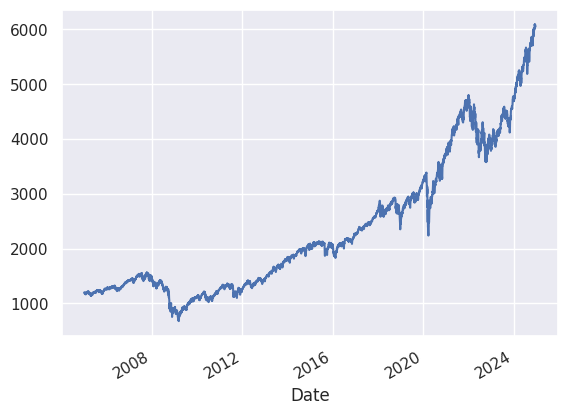

In [5]:
df['Close'].plot()

#### ADF test for stationarity

One of the main issue of financial time series is that they often present non stationary characteristics since stocks and index prices are characterized by long run increasing trends, hence non constant statistics. Non constant statistics refers to changes of its key statistical properties like mean, variance, autocorrelation over time.

Just with a visual ispection of the plot above we can infer that the series is non stationary, however we may still want to test statistically this hypothesis.

The Augmented Dickey Fuller test is a statistical test for the stationarity of a time series. The test evaluates whether a unit root is present in the data, indicating non-stationarity. The null hypothesis of ADF test is that the time series data is non-stationary.

In [6]:
print('p-value for ADF test: ', adfuller(df['Close'])[1])

# H0 : non stationarity
# reject for p-values < 0.05 (5%)

p-value for ADF test:  0.9990193377175978


The pvalue is really high hence we can't reject the null hypothesis and confirm that the series is non stationary.

Stock and index prices are not stationary time series, so before starting to model the series we need to convert it in a stationary time series.

#### Calculate log returns

In order to make the series stationary, we can differentiate it, for instance by calculating the returns, commonly done in financial econometrics using log returns.

This transformation is preferred because:

It removes trends and non-constant levels present in raw price series,

It stabilizes the variance, making the time series more suitable for modeling,

It often yields a process with constant mean and variance, satisfying the conditions for weak stationarity.

In financial econometrics it's common to calculate Log returns instead of returns:

$return_t = \log(\frac{P_t}{P_{t-1}}) = \log P_t - \log{P_{t-1}}$

In [7]:
returns = pd.Series(np.log(df['Close']/df['Close'].shift(1)), index = df.index).dropna()
returns.head()

,Close
Date,
2005-01-04,-0.011740
2005-01-05,-0.003634
2005-01-06,0.003500
2005-01-07,-0.001432
2005-01-10,0.003417


<Axes: xlabel='Date'>

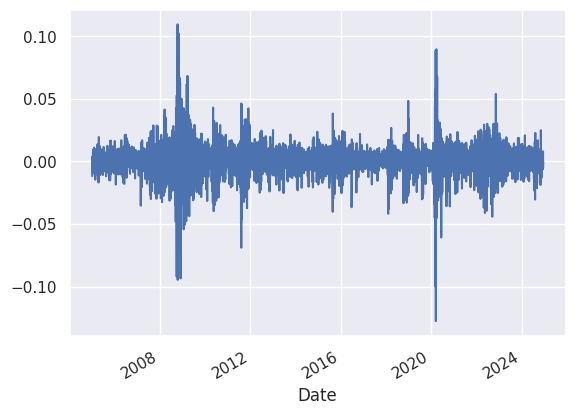

In [8]:
returns.plot()

In [9]:
print('p-value for ADF test: ', adfuller(returns)[1])

# H0 : non stationarity
# reject for p-values < 0.05 (5%)

p-value for ADF test:  5.795143857185276e-30


Now the series looks stationary, and the stationary is confirmed also by the very low pvalue for the ADF test that allow us to reject the null hypothesis of non stationarity.

#### Define plotting function for the time series

This function will be useful to take a look at a series' characteristics by looking at the QQ plot, ACF plot and PACF plot.

In [10]:
def ts_plot(series : pd.Series, max_lags : int, title : str):

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot the series
    axs[0, 0].plot(series)
    axs[0, 0].set_title('Series')

    # QQPLOT
    qqplot(series, ax = axs[0, 1], line='s')
    axs[0, 1].set_title('QQ plot')

    # ACF PLOT
    plot_acf(series, lags=max_lags, ax = axs[1, 0], zero=False) # zero = False to not include lag 0
    axs[1, 0].set_title('Autocorrelation plot')
    axs[1, 0].set_xlabel('Lag')

    # PACF PLOT
    plot_pacf(series, lags=max_lags, ax = axs[1, 1], zero=False)
    axs[1, 1].set_title('Partial Autocorrelation plot')
    axs[1, 1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=20) # add a superior title for the figure
    # autoscale both correlation plots
    axs[1, 0].autoscale()
    axs[1, 1].autoscale()

Before proceeding to model the returns volatility using GARCH models, we shall discuss some characteristics of the returns and of the volatily of returns.

## Analysis of FTSE MIB returns, distribution and anomalies <a name="paragraph1"></a>

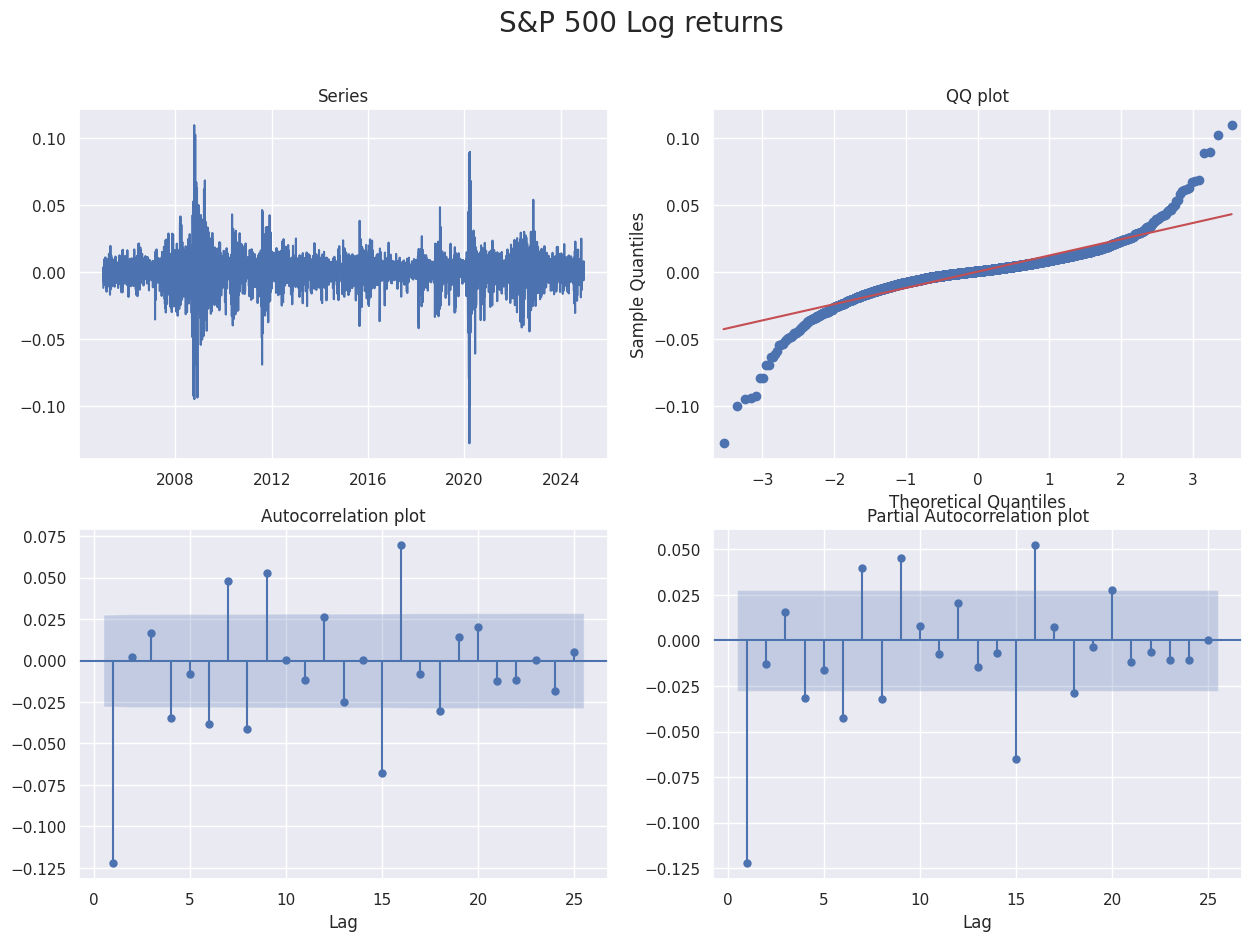

In [11]:
ts_plot(returns, 25, 'S&P 500 Log returns')

The log return series of the S&P 500 fluctuates around zero without a clear trend, suggesting stationarity in mean. However, periods of high and low volatility alternate, showing volatility clustering.

The QQ plot indicates heavy tails in the return distribution, as extreme values occur more frequently than under a normal distribution.

The ACF and PACF plots of the returns show no strong autocorrelation, suggesting little linear predictability. However, volatility may still be predictable, as seen in squared returns.

These features imply time-varying variance, or heteroskedasticity. Thus, models like GARCH are suitable for capturing the volatility structure in the return series.

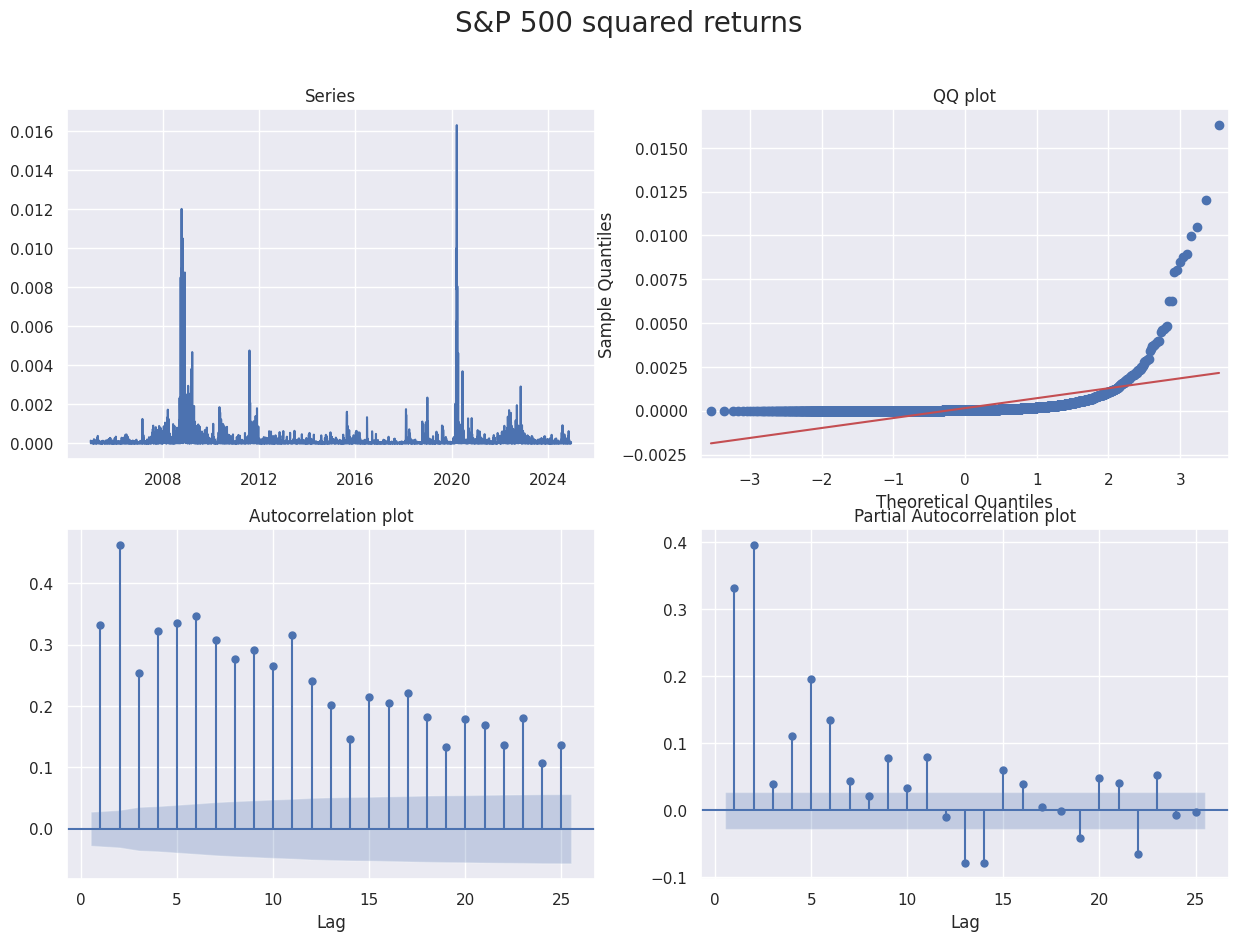

In [12]:
ts_plot(returns**2, 25, 'S&P 500 squared returns')

In the time series plot (top left), there are noticeable periods where volatility spikes and then clusters, followed by calm periods, this is classic volatility clustering, a common feature in financial data. The QQ plot (top right) shows a heavy-tailed distribution with deviations from the normal distribution, especially at the tails, suggesting non-normality.

The autocorrelation plot (bottom left) shows persistent and significant autocorrelations at many lags, and the partial autocorrelation plot (bottom right) confirms that this persistence extends over several lags. Together, these indicate that the squared returns are serially correlated, meaning the variance of returns is time-dependent.

This behavior confirms that while the original returns may be uncorrelated, their variance is not, justifying the use of models like ARCH or GARCH, which are designed to model such heteroskedasticity and volatility patterns in financial time series.

#### Ljung-Box test

Another way to check the presence of autocorrelation in the data is using the Ljung Box test statistic, for which:

- $H_0$ : The data are independently distributed; No Autocorrelation
- $H_1$ : The data are not independently distributed; they exhibit serial correlation.

In [13]:
sm.stats.acorr_ljungbox(returns**2, lags=None, auto_lag=True)

,lb_stat,lb_pvalue
1,554.341840,1.430442e-122
2,1627.785634,0.000000e+00
3,1952.131941,0.000000e+00
4,2475.055161,0.000000e+00
5,3042.882529,0.000000e+00
...,...,...
2930,22429.926258,0.000000e+00
2931,22430.172032,0.000000e+00
2932,22430.193342,0.000000e+00
2933,22436.240315,0.000000e+00


In [14]:
# check if any lag pvalue is statistically not significant
(sm.stats.acorr_ljungbox(returns**2, lags=None, auto_lag=True)['lb_pvalue'] > 0.05).sum()

np.int64(0)

Since all p-values are smaller than 0.05 we reject the null hypotheses and can conclude that there is AUTOCORRELATION in the variance of the data (in the squared returns), which verifies what we concluded from the plots.

#### Returns Distribution

Let's now focus on the distribution of the returns and observe possible anomalies.

Text(0.5, 1.0, '2nd anomaly: higher spike of S&P 500 returns distribution')

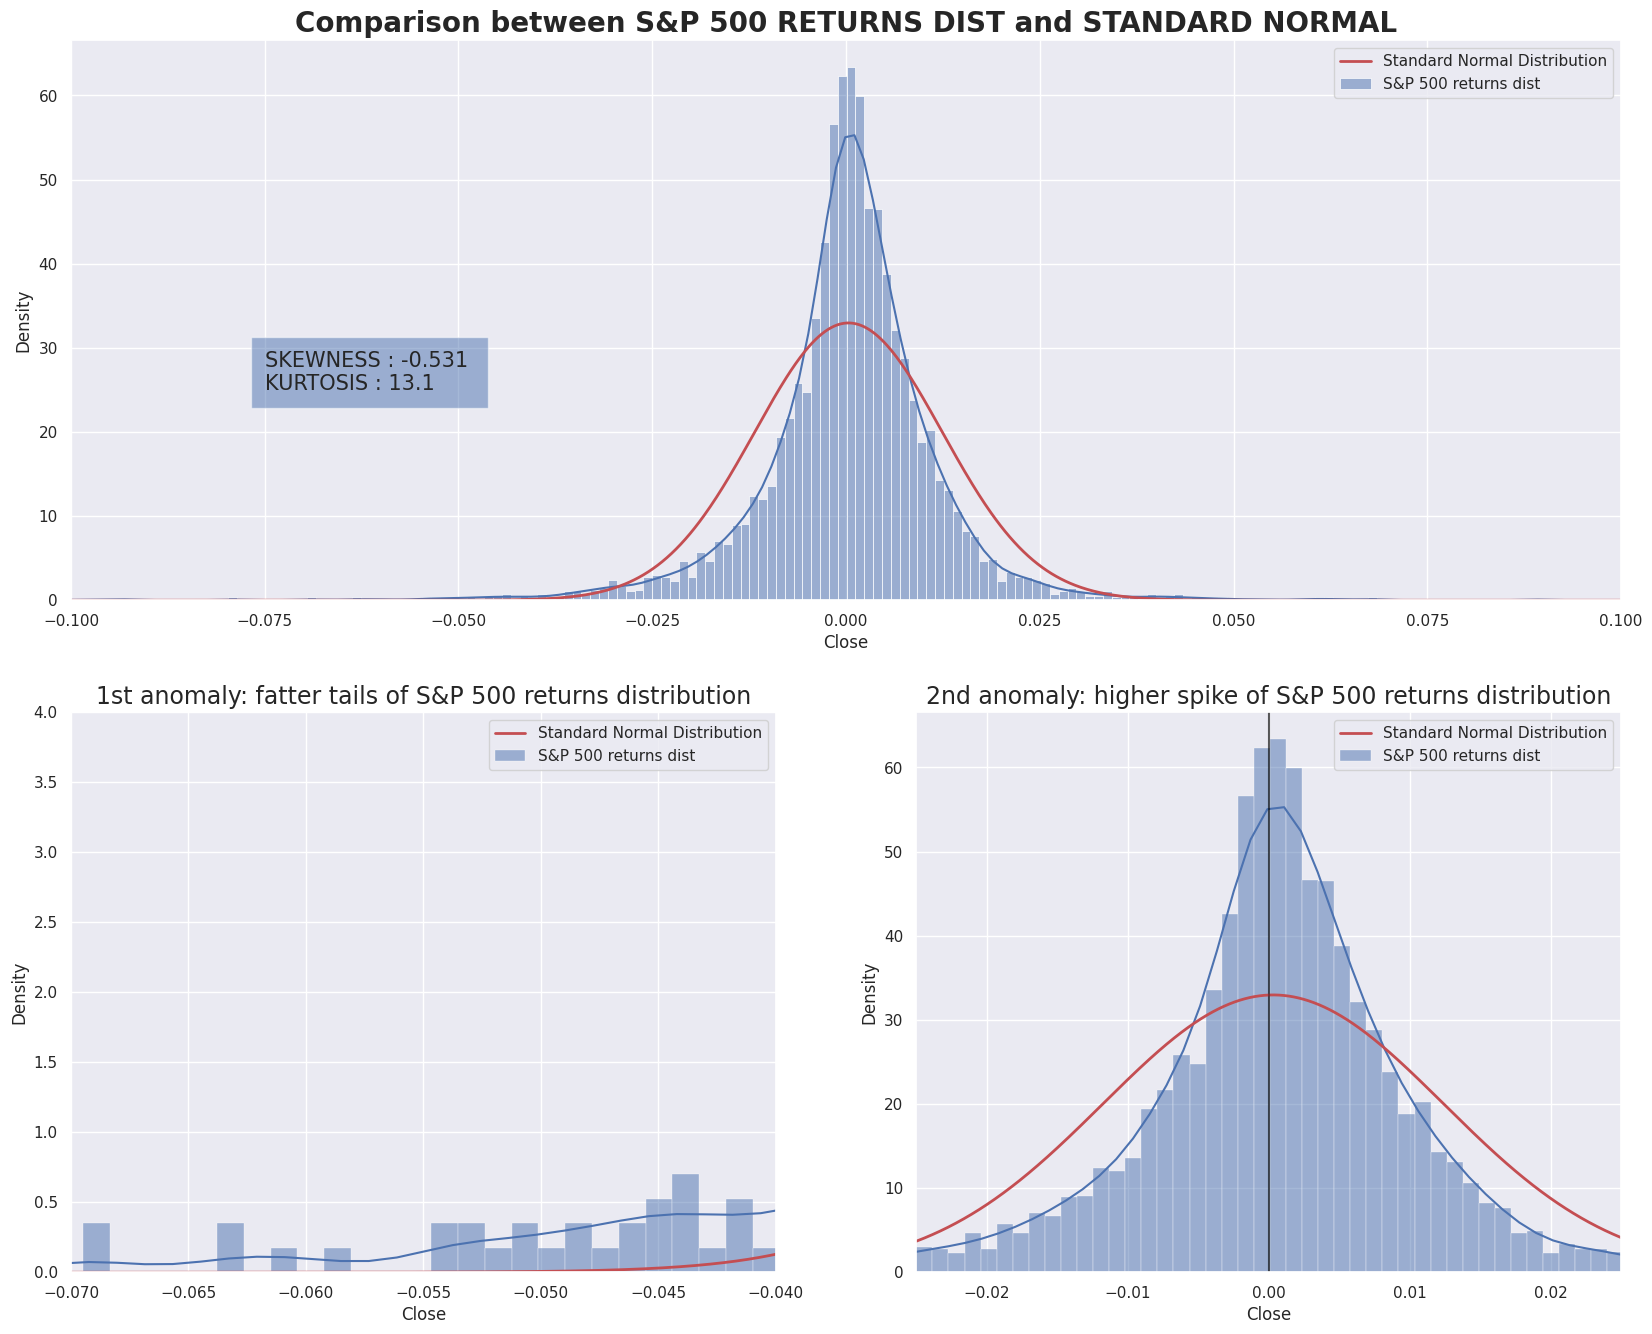

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :]) # add one subplot in the two grids of the first row
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])


sns.histplot(returns, stat='density', kde=True, label='S&P 500 returns dist')
ax.set_xlim([-0.10, 0.10])
x = np.linspace(-0.1, 0.1, 1000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
ax.plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
ax.legend()
ax.set_title('Comparison between S&P 500 RETURNS DIST and STANDARD NORMAL', fontsize=20, fontweight='bold')
ax.text(-0.075, 25, f'SKEWNESS : {returns.skew():.3} \nKURTOSIS : {returns.kurtosis():.3}', style='normal',
        bbox={'alpha': 0.5, 'pad': 10}, fontsize=15)

# Lower-left plot (focus on left fat tail)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 0], label='S&P 500 returns dist')
axs[1, 0].set_xlim([-0.07, -0.04])
axs[1, 0].set_ylim([0, 4])
x = np.linspace(-0.07, -0.04, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 0].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 0].legend()
axs[1, 0].set_title('1st anomaly: fatter tails of S&P 500 returns distribution', fontsize=17)


# Lower-right plot (focus on the central leptokurticity)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 1], label='S&P 500 returns dist')
axs[1, 1].set_xlim([-0.025, +0.025])
axs[1, 1].axvline(0, c='black', alpha=0.4)
x = np.linspace(-0.025, +0.025, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 1].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 1].axvline(0, c='black', alpha=0.4)
axs[1, 1].legend()
axs[1, 1].set_title('2nd anomaly: higher spike of S&P 500 returns distribution', fontsize=17)



In [16]:
print('Skewness:', returns.skew(), '\nKurtosis:', returns.kurtosis())

Skewness: -0.5310657651032167 
Kurtosis: 13.06488293410101


The analysis of the S&P 500 log returns distribution reveals key departures from the assumptions of normality, particularly in terms of kurtosis and skewness. First, the returns exhibit pronounced leptokurticity, which is evident from the high positive value of kurtosis and the sharp central peak in the distribution. This leptokurtic shape also implies the presence of fat tails, meaning the probability of observing extreme returns—both gains and losses—is significantly higher than what a normal distribution would predict. This behavior is typical in equity market returns and is crucial for understanding the risk of sudden, large price movements.

Second, the returns distribution shows negative skewness. Compared to a symmetric normal distribution, this skewness reflects a longer left tail, indicating that large negative returns are more likely than large positive ones of the same magnitude. Such asymmetry is particularly relevant for risk management, as it suggests a bias toward downside risk, an important consideration for financial institutions when designing strategies to mitigate potential losses.

These features fat tails and skewness are part of the broader stylized facts of financial return distributions. Two additional facts often observed in financial time series include the difference in behavior between short-term and long-term returns, where short-term returns typically exhibit more noise and less mean reversion, and the tendency of extreme returns to occur in clusters, a phenomenon known as volatility clustering, where periods of high volatility are followed by more volatile periods.

From our plotted S&P 500 return data, we clearly observe a sharp central spike, fat tails on both ends of the distribution, and a noticeable leftward skew. These insights validate the non-normality of financial returns and underscore the need for more robust models, such as GARCH-type models with fat-tailed innovations, to accurately capture the true risk and return dynamics of financial markets.

## Volatility Clustering and Market Regimes

After dealing with the main returns anomalies, there is still a second issue that we've just introduced: volatility clustering.

A visual inspection of the returns series should give us a first glance at this phenomenom. In the following figure, the returns series is plotted with a 21 days rolling volatility.

(-0.1, 0.1)

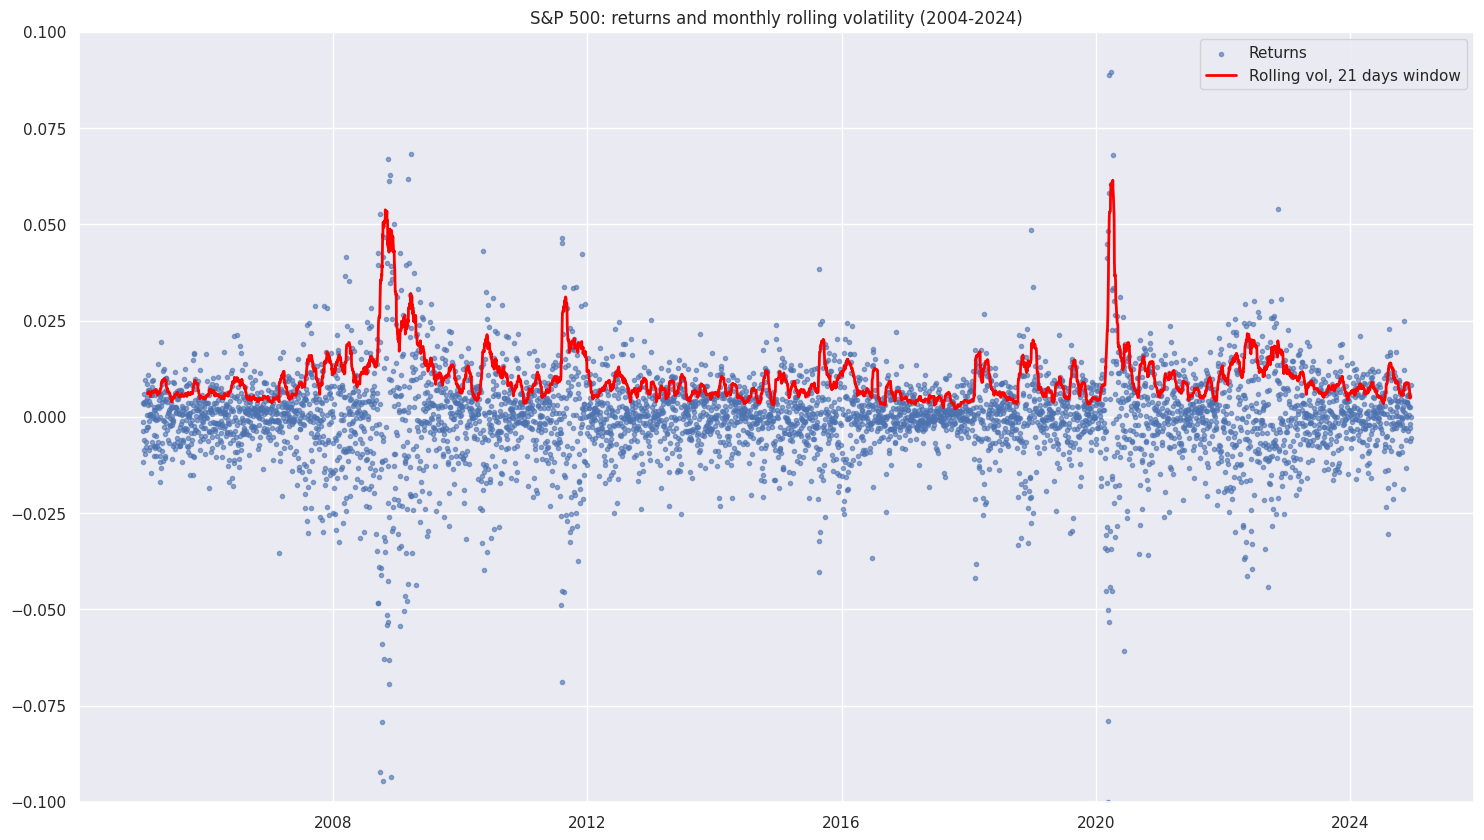

In [17]:
plt.figure(figsize=(18, 10))
plt.scatter(returns.index, returns, marker='.', label='Returns', alpha=0.6)

# Calculate the 1 month rolling volatility (21 trading days in a month)
onem_vol = pd.Series(returns.rolling(window=21).std(), index = returns.index)

plt.plot(onem_vol, color='red', label='Rolling vol, 21 days window', linewidth=2)

plt.title('S&P 500: returns and monthly rolling volatility (2004-2024)')
plt.legend()
plt.ylim([-0.1, +0.1])

#### Volatility clustering

As we can see from the previous plot, it's clear how there are alternating periods in the behaviour of the returns (and its volatility). There is the persistence of periods in which the oscillations of the returns are more pronounced and cause a persistent increase in the volatility of the market. On the contrary, there are periods in which the market returns are more stable and tend to be associated with prolonged phases of constant volatility.

These two arguments form the basis of the **volatility clustering** phenomenom.

> Volatility clustering refers to the observation that large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes. This phenomenom led during the 80s the development of new models that could be sensible and robust to this behaviour in the volatility: the ARCH and GARCH family of models.

#### Market regimes

As we have understood, this periods of concentrated high volatility are tipycal of more general trends in the market: market regimes. But how we can observe these regimes? The following part of the notebook will try to showcase the presence of different regimes in the series of S&P 500 by leveraging an unsupervised learning technique, KMEANS.

### KMeans visualization of the Volatility

We can use an unsupervised learning technique, Kmeans clustering, to visualize the presence of different clusters of volatility, where each cluster correspond to a different market regime with different statistical properties (as we'll see also later with the conditioned kernel density plots).

In [18]:
from sklearn.cluster import KMeans

# let's recreate the series of rolling volatilities for 90 days (~3 months) days and annualize it
x = np.sqrt(251) * pd.Series(returns.rolling(window=90).std().dropna())
x = x.to_frame()
x.rename(columns = {'Close' : '90 days Rolling Vol'}, inplace=True) #change column name
x.head()

,90 days Rolling Vol
Date,
2005-05-12,0.115422
2005-05-13,0.114051
2005-05-16,0.115210
2005-05-17,0.115660
2005-05-18,0.116860


Now we'll create a function that clusters using Kmeans the 90 days rolling volatility into n groups (that is k, to be defined).

In [19]:
# This function will cluster the 90 days rolling volatilies into n groups (n to be defined)

def kmeans_cluster(x, n_clusters : int):
    kmeans = KMeans(n_clusters = n_clusters, n_init='auto')
    kmeans.fit(x) #fit the Kmeans algo onto the data

    clusters = kmeans.predict(x) #calculate the n clusters

    # Store the results in two data structures:

    # 1) CREATE CLUSTER SERIES
    # The following series will store the cluster center of each element in the original series
    cluster_series = pd.Series(
        # Creating a Series using list comprehension:
        # For each element in clusters (contain cluster center of each element of the original series),
        # store and round the cluster center of the ith element of the series in a pd.Series object
        [
            round(kmeans.cluster_centers_[cluster_id, 0], 2)  #round the clusters centers to the 2nd decimals (just for clarity)
            for cluster_id in clusters
        ],
        index = x.index # pass the original series' index to the new series
    )

    # 2) CREATE CLUSTER DATAFRAME
    clustering_df = {}  #initialize an empty dictionary
    for cluster_id in range(n_clusters):
        # Extract the aproximated vol level of the cluster center (for each cluster)
        volatility_level = round(kmeans.cluster_centers_[cluster_id, 0], 2)

        # For each cluster, store a boolean indicator for the observations that fall within the cluster
        # -> the df is going to be a 3 column dataframe with each column referred to a cluster
        # -> an observation in a specific row (time ordered series) will have TRUE(=1) for
        #    a specific column only if part of the relative cluster
        clustering_df[f'Cluster {volatility_level:.3}'] = (clusters == cluster_id).astype(float)
                                                                                # astype used to convert boolean in numeric

    clustering_df = pd.DataFrame(clustering_df, index=x.index) # convert list in a df
    clustering_df = clustering_df[sorted(clustering_df.columns)] # sort the columns of the df

    return clustering_df, cluster_series

Let's discuss the two data structures created in the above function :

1) `CREATE CLUSTER SERIES`
    This piece of code is creating a series (with the same dimension as the x one), in which each element have the cluster center reference. For each day, the value will indicate the cluster membership (it will indicate the center of the cluster for which the obsevation is part of, basically, to which market regime the observation corresponds).

2) `CREATE CLUSTER DATAFRAME`
    This following part of the function is more difficult. Its main purpose it's extracting a dataframe in the format of a one hot encoding. The dataframe will have as many columns as the **k** defined at the beginning, and every element in the series will have a value = 1 if it belongs to a specific cluster, a specific column.

In [20]:
KM_cluster_df, KM_cluster_series = kmeans_cluster(x, 3)
KM_cluster_df.head()

,Cluster 0.12,Cluster 0.22,Cluster 0.51
Date,,,
2005-05-12,1.0,0.0,0.0
2005-05-13,1.0,0.0,0.0
2005-05-16,1.0,0.0,0.0
2005-05-17,1.0,0.0,0.0
2005-05-18,1.0,0.0,0.0


In [21]:
KM_cluster_series[:5] #the value related to each date is the cluster center for which the day is part of

,0
Date,
2005-05-12,0.12
2005-05-13,0.12
2005-05-16,0.12
2005-05-17,0.12
2005-05-18,0.12


#### Volatility clusters and 3 months rolling volatility

For each column of the cluster dataframe, we plot all the observations that are part of one cluster (that have value = 1 in that column) and use the function `fill_between` to colour the area between 0 and 1 (since `KM_cluster_df` rows have value =1 only for the specific column, the specific cluster, for which they have membership)

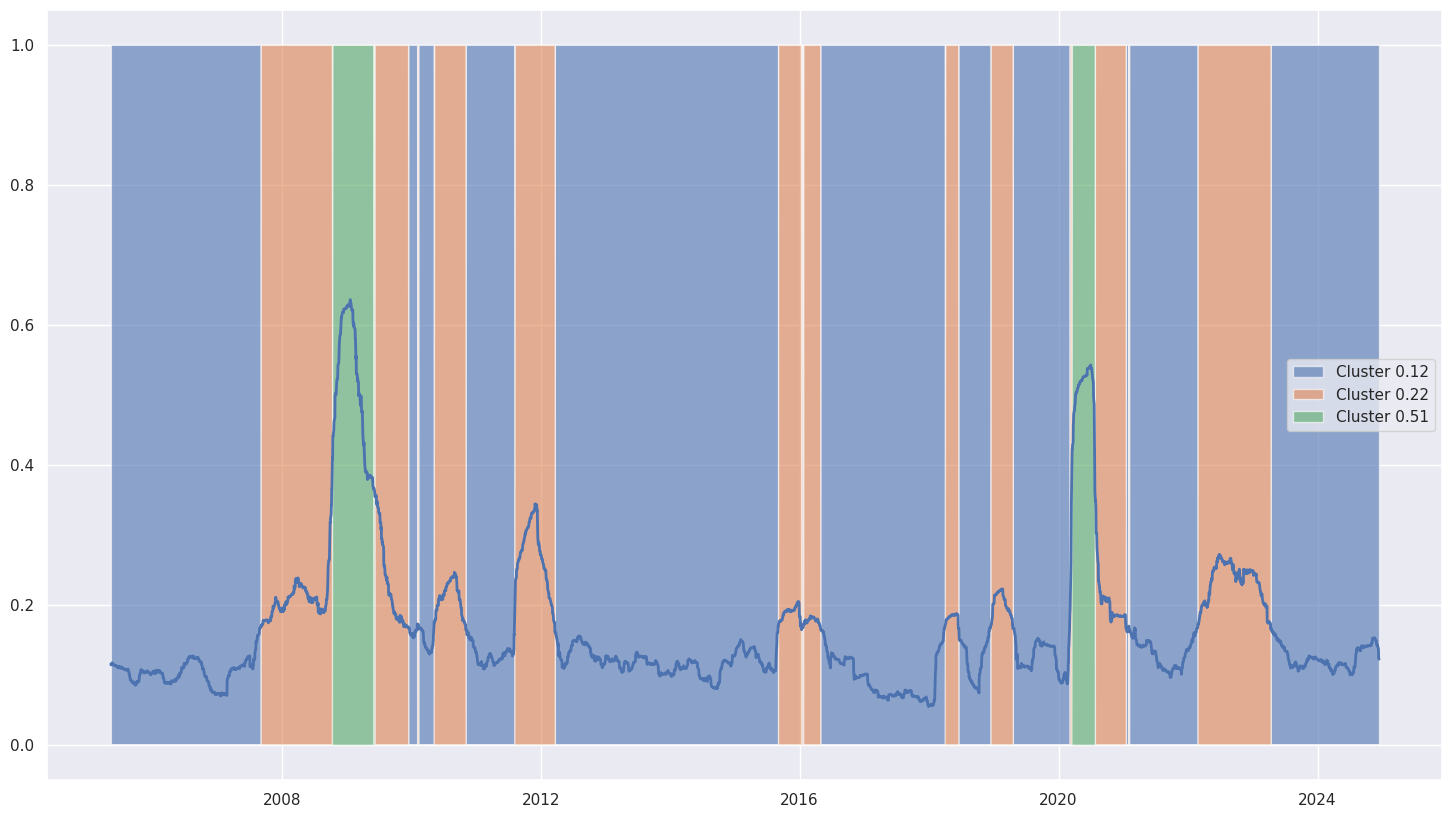

In [22]:
plt.figure(figsize=(18, 10))

for col in KM_cluster_df.columns:
    plt.fill_between(KM_cluster_df[col].index, 0, KM_cluster_df[col], alpha=0.6, label=col)
    # KM_cluster_df will have 1 if the element of the series have membership to one cluster

plt.plot(x, linewidth = 2)
plt.legend()

#### Volatility clusters and S&P 500 PERFORMANCE

Now we need to scale the area coloured by `fill_between` in between 0 and the maximum peaked by the S&P 500 index.
To do so we add the peaked maximum to each observation = 1, in each column.

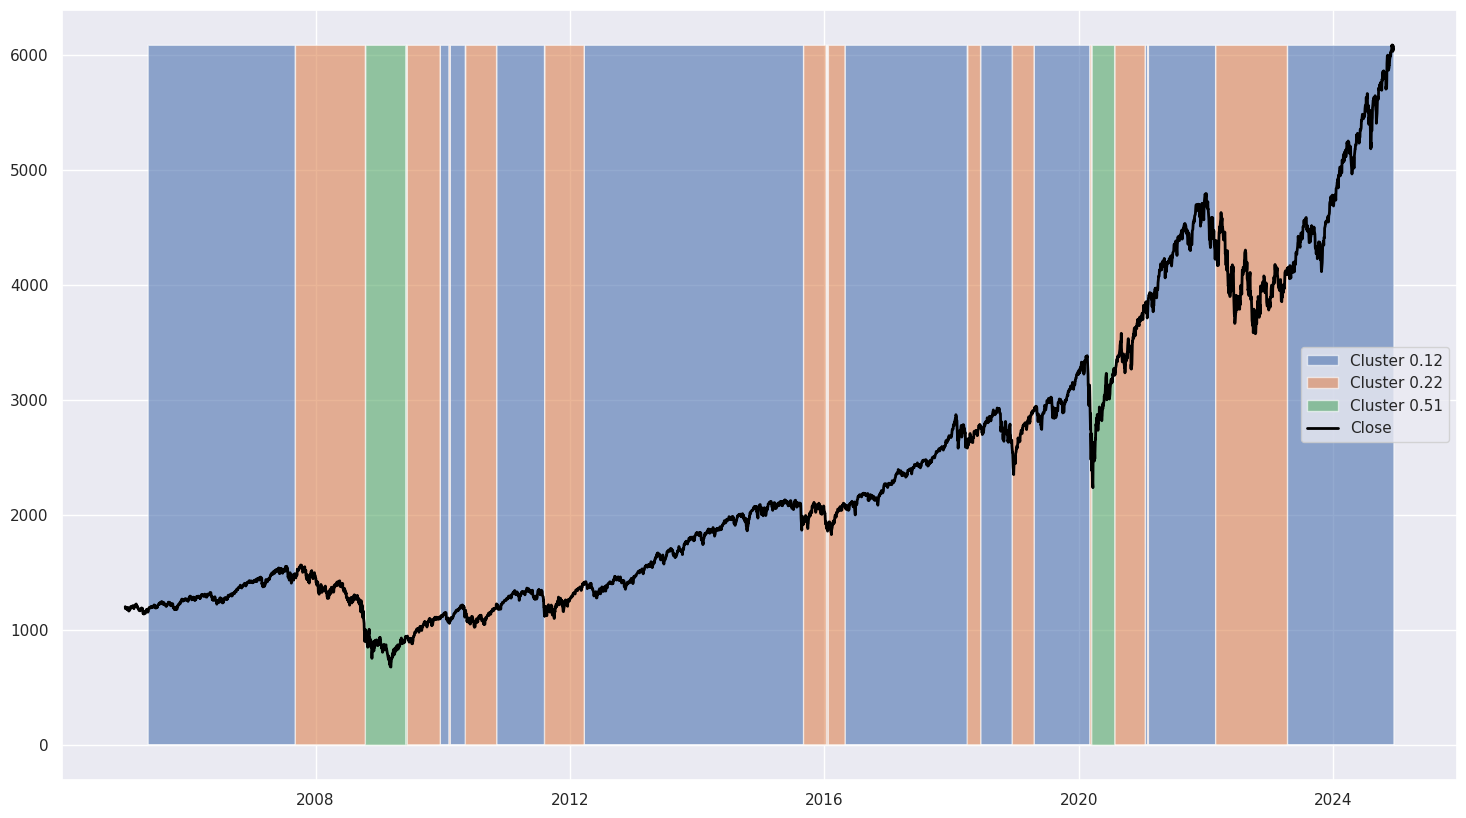

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure KM_cluster_df is a numeric DataFrame
temp = KM_cluster_df.copy()
temp = temp.apply(pd.to_numeric, errors='coerce').fillna(0)

# Add max price to cells with value == 1
adj_max = df['Close'].max()
temp = temp.where(temp != 1, temp + adj_max)

# Plotting
plt.figure(figsize=(18, 10))

# Fill each cluster's region
for col in temp.columns:
    plt.fill_between(temp.index, 0, temp[col], alpha=0.6, label=col)

# Plot the price series
plt.plot(df['Close'], linewidth=2, label='Close', color='black')

# Beautify
plt.legend()


#### Volatility clusters and S&P 500 PERFORMANCE (2007-2012)

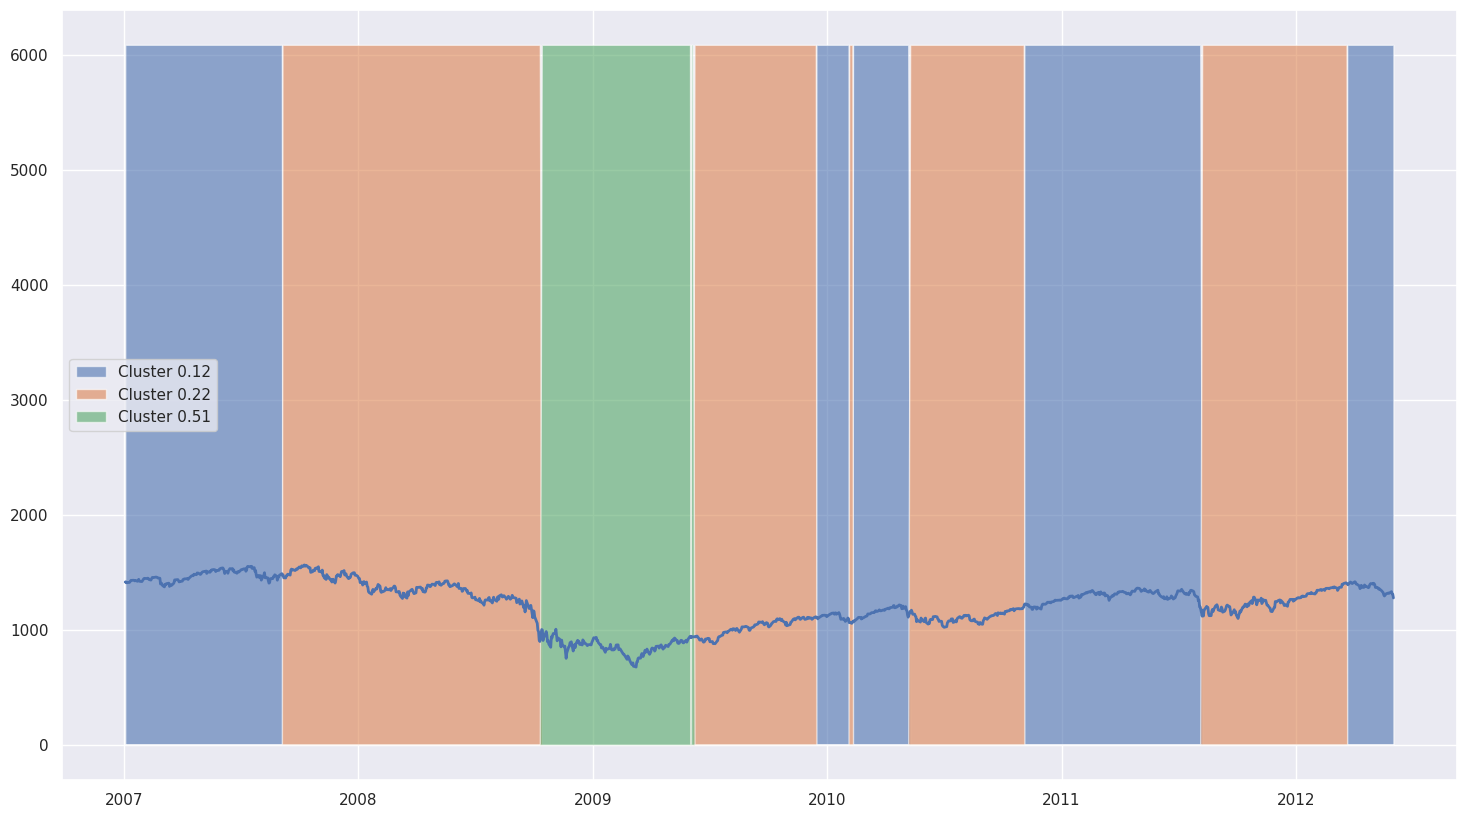

In [24]:
plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col]['2007-01-01' : '2012-06-01'].index, 0, temp[col]['2007-01-01' : '2012-06-01'], alpha=0.6, label=col)

plt.plot(df['Close']['2007-01-01' : '2012-06-01'], linewidth = 2)
plt.legend()

As we can see from the plot above, the cluster with higher vol (0.51) is the one that particularly characterized the 2008-2009 crisis (from the end of 2008 to mid of 2009) and part of the following debt crisis during 2011-2012. This periods are the  periods in which the markets are more stressed, there is a higher volatility, and returns are more probable in the extreme of the distribution (conditioned upon the specific market regimes we are considering).
- The green areas belongs to the more volatile and riskier market regime, with higher vol and extreme positive or negative returns.
- The orange are are part of a less riskier market regime.
- The blue areas belongs to a market regime in which the volatility is the lower between the three.

#### Volatility distributions conditioned on Market Regimes

One further step we can do is to show the different statistical distributions of the three market regimes. Basically, we plot the distribution of volatility conditioned on the three market regimes (the three clusters) and we expect the distributions to be different.

In [25]:
# Now we concatenate the volatility series with the regimes associated to each date (the KM_cluster_series)

kde_plot_df = pd.concat([x, KM_cluster_series.to_frame(name='Regimes')], axis=1)
kde_plot_df.head()

,90 days Rolling Vol,Regimes
Date,,
2005-05-12,0.115422,0.12
2005-05-13,0.114051,0.12
2005-05-16,0.115210,0.12
2005-05-17,0.115660,0.12
2005-05-18,0.116860,0.12


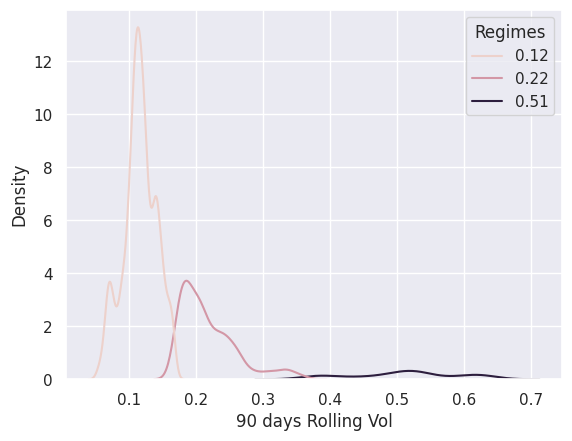

In [26]:
# With seaborn plot a kernel density conditioned on the three market regimes (using option hue='Regimes)

sns.kdeplot(kde_plot_df, x=kde_plot_df.columns[0], hue='Regimes')
plt.show()

This plot show the distribution of the volatily in the three different regimes we identified with the KMEANS.

#### Returns distributions conditioned on Market Regimes

We can also look at the distribution of the returns under the three different regimes.

In [27]:
#First, concatenate the cluster series (containing the cluster centers) and the return series
kde_plot_ret_df = pd.concat([returns, KM_cluster_series.to_frame(name='Regimes')], axis=1)
kde_plot_ret_df.rename(columns = {'Close' : 'Returns'}, inplace=True)
kde_plot_ret_df.dropna(inplace=True)
kde_plot_ret_df.head()


,Returns,Regimes
Date,,
2005-05-12,-0.010084,0.12
2005-05-13,-0.004591,0.12
2005-05-16,0.010036,0.12
2005-05-17,0.006933,0.12
2005-05-18,0.009969,0.12


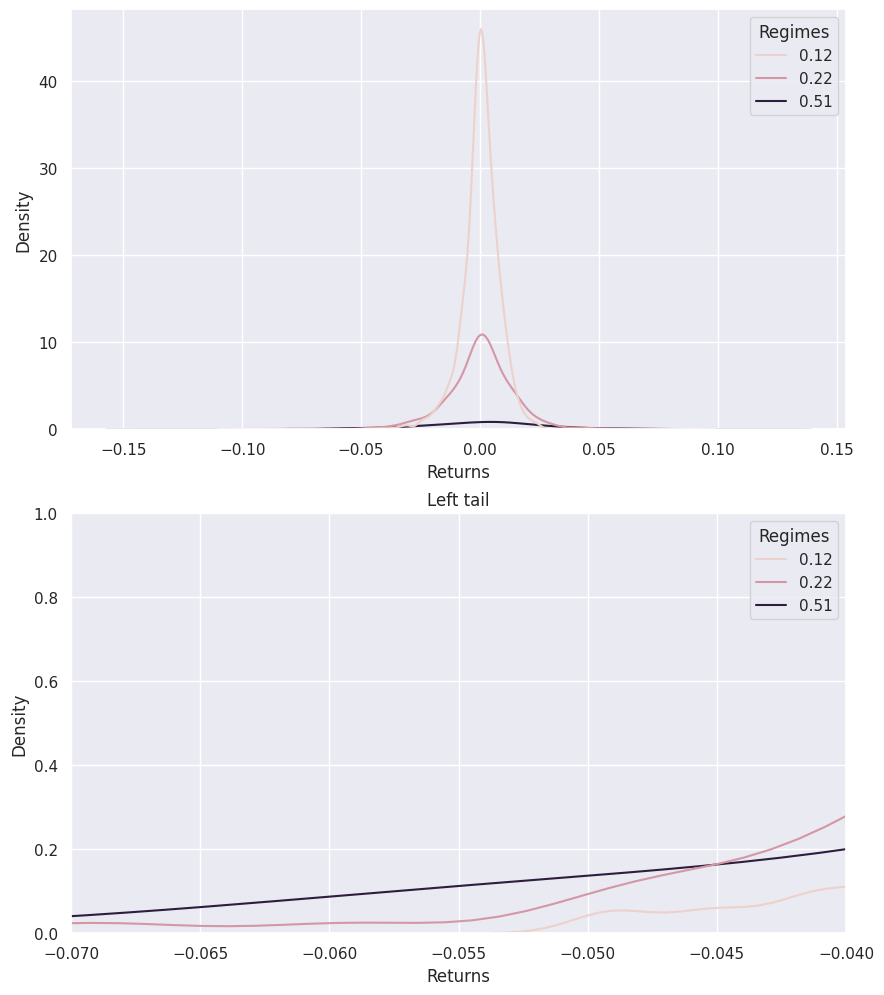

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))


sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[0])

# Focus on the left tail
sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[1])
axs[1].set_xlim([-0.07, -0.04])
axs[1].set_ylim([0, 1])
axs[1].set_title('Left tail')

plt.show()

As we can see in the black market regime (the one with higher volatility) the spike of the distribution is significantly lower, central returns (small movements in the market) are less probable to happen with respect to other market regimes. Instead, tails are clearly heavier and so extreme returns are more likely to happen. This is a consequence of periods of financial turmoil with higher volatility and hence higher probability of extreme returns in the market.

It's clear from this part of the analysis that a model capable of dealing with the returns anomalies and with the volatility eteroschedasticity is necessary. For this reasons, ARCH and GARCH model were developed and are going to be discussed shortly.

## Data Preprocessing

#### Scale Returns

In order for the returns to be fed to the model, we should scale them by multiplying them by 100 (creating integer % values for the returns).
This is a requirement of the `ARCH` library we are going to use to model GARCH models.


In [29]:
returns *= 100
returns[:10]

,Close
Date,
2005-01-04,-1.174000
2005-01-05,-0.363444
2005-01-06,0.349973
2005-01-07,-0.143220
2005-01-10,0.341693
2005-01-11,-0.611825
2005-01-12,0.397350
2005-01-13,-0.866758
2005-01-14,0.598660


### Relaized Volatality
Before applying volatility models, we need a benchmark to evaluate their performance. However, true volatility defined by the variance or standard deviation of returns—is unobservable because it is a latent feature of the data-generating process. This makes model comparison challenging.

To address this, we estimate *realized volatility* using proxies. One approach is implied volatility from options prices, which reflects market expectations under the assumption of geometric Brownian motion. Another method uses high-frequency intraday returns to compute daily volatility from squared returns.

Alternatively, as proposed by Pagan & Schwert, one can use the squared residuals from a conditional mean model like:

$$
r_t = m_t + \epsilon_t
$$

where \( m_t \) captures trends through AR/MA terms.

A widely used formula-based approach is the **Garman-Klass estimator**, which uses open, high, low, and close prices to compute a more efficient daily volatility proxy:

$$
\sigma_t^2 = 0.511(u - d)^2 - 0.019[c(u + d) - 2ud] - 0.383c^2
$$

Here,

- \( u = \log(\text{High}) - \log(\text{Open}) \)  
- \( d = \log(\text{Low}) - \log(\text{Open}) \)  
- \( c = \log(\text{Close}) - \log(\text{Open}) \)  

This estimator captures intraday price dynamics and is often used when high-frequency data is unavailable.


In [30]:
def GarmanKlass(data : pd.DataFrame):

    # Extract the series length
    n = len(data)

    # Adjust the high low open close with the adjusting coefficient
    H = np.log(data['High'] )
    L = np.log(data['Low'] )
    O = np.log(data['Open'] )
    C = np.log(data['Close'] )

    # Calculate normalized returns
    u = (H - O) * 100 #between high and open
    d = (L - O) * 100 #between low and open
    c = (C - O) * 100 #between close and open

    ## Calculate the GK VARIANCE estimate
    x = 0.511 * (u - d)**2 + (-0.019) * (c * (u + d) - 2 * u * d) + (-0.383) * c**2

    # return the series
    return pd.Series(np.sqrt(x), index = data.index, name='Volatility')

realized_vol = GarmanKlass(df[['Open', 'High', 'Low', 'Close']])
realized_vol.head()

,Volatility
Date,
2005-01-03,0.887971
2005-01-04,0.962453
2005-01-05,0.487817
2005-01-06,0.448571
2005-01-07,0.592141


<Axes: xlabel='Date'>

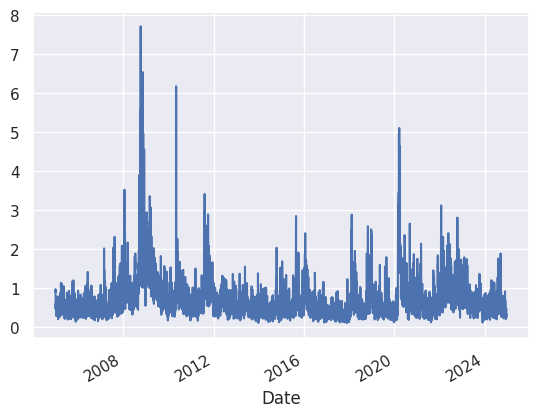

In [31]:
realized_vol.plot()

## ARCH & GARCH Models Intuition

#### Returns

As we understood before, financial returns appeared to be serially uncorrelated but dependent in some way.
This is the basic idea of volatility models that try to capture this sort of dependence in the returns and describe the returns as:

$$r_t = \mu_t + \epsilon_t$$

where $\mu_t$ is a mean process that can be defined with AR and MA models (or as a costant process), and $\epsilon_t$ is referred as the shock of innovation of the asset return at time t (the residual).

#### ARCH

The `ARCH` model was the first heteroschedasticity-robust model. It was developed by Engle in 1982.

The basic idea of ARCH models is that the shock $\epsilon_t$ at of an asset return is serially uncorrelated, but dependent, and that this dependence can be described by a quadratic function of its ($m$) lagged values, with the following equations:

$$\epsilon_t = \sigma_t  z_t \ \ \ \ (1) $$
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + + \alpha_2 \epsilon_{t-2}^2 + ... + \alpha_m \epsilon_{t-m}^2 \ \ \ \ (2)$$


where:
- $z_t$ is a sequence of independent and identically distributed random variables with mean 0 and variance 1,
- $\omega > 0$
- $\alpha_i \ge 0$

Notably, the effect of the lagged errors on the variance can be described - as Tsay explains in *Analysis of Financial Time Series* - as:

>From the structure of the model, it is seen that large past squared shocks $\epsilon_{t-i}^2$ imply a large conditional variance $\sigma_t^2$ for the innovation $\epsilon_t$. Consequently, $\epsilon_t$ tends to assume a large value (in modulus). This means that, under the ARCH framework, <u> large shocks tend to be followed by another large shock </u>. Here I use the word tend because a large variance does not necessarily produce a large realization. It only says that the probability of obtaining a large variate is greater than that of a smaller variance. This feature is similar to the volatility clusterings observed in asset returns.

From this consideration of Tsay follows that ARCH models should be capable of dealing with the heteroschedasticity observed in the volatility of returns, by leveraging on the relation between past shocks and future shocks, transmitted through the conditional variance.   




#### GARCH

Following the idea of Engle, its alumn Bollerslev developed the GARCH model, a generalized extension of the ARCH.


In studies from the literature, usually a GARCH(1,1) provide an appropriate fit to financial data. This model is composed by three equations:

$$ \epsilon_t = r_t - \mu_t \ \  \text{from} \ \ r_t = \mu_t + \epsilon_t \ \ \ \ (1) $$
$$\epsilon_t = \sigma_t  z_t \ \ \ \ (2)$$     
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2  \ \ \ \ (3)$$

In equation (2) $z_t$ is the underlying distribution of the standardized residuals( $= \frac{\epsilon_t}{\sigma_t}$ ).


Intuitively `GARCH` provide a variance forecast through equation (3), the **variance process**. This forecast can be interpreted as a <u> weighted average of three different forecasts</u>.

- $\omega$ is  first  a constant variance that corresponds to the long run average.
- $\epsilon_{t-1}$ is the new information that was not available when the previous forecast was made.
- $\sigma_{t-1}^2$ is the forecast that was made in the previous period.

The parameters associated to the last two components determine how fast the variance changes with new information and how fast it reverts to its long run mean  $\large\omega$ :
- The larger is $\alpha$, the bigger is the immediate impact of the past shock on the volatility
- The larger is $\beta$, the longer is the duration of the impact

Let's generalize the GARCH variance process to order (p, q):

$$\large \sigma_t^2 = \omega + \sum_{i=1}^m \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^s \beta_i \sigma_{t-j}^2  \ \ \ \ (3)$$

for which the constraints are:

- $\omega > 0$
- $\alpha_i \ge 0$
- $\beta_j \ge 0$
- $\sum_{i=1}^{max(m, s)}{(\alpha_i +  \beta_i)}$

Of course, equation (3) reduces to a pure ARCH(m) model if $s = 0$


#### What is the main advantage of using GARCH instead of ARCH?
GARCH was first developed to reduce the number of parameters to be estimated. Since GARCH include lagged forecasts of the conditional variance, intuitetively those contains the past informations that in the ARCH model had to be sourced by including a greater number of lags of the $\epsilon$ shocks (or residuals).

Since the GARCH is the most used model in real world, this notebook will integrate it and extend the analysis to a couple of GARCH-derived models.

#### Test for ARCH effects/structure (Engle's Lagrange Multiplier Test)


Before starting to model the returns in order to capture the volatility, we should test the presence of ARCH structure in the returns. The test to use is the LM test for which:
- $H_0$ : no ARCH effects


In [32]:
from statsmodels.stats.diagnostic import het_arch

print('LM test pvalue: ', het_arch(returns)[1]) #returns the pvalue

LM test pvalue:  0.0


As we can see, the pvalue is so small that we reject the null Hypotheses of no ARCH effects and confirm strong signs of ARCH effects. This is a clear motivation for the use of an ARCH-based model.

#### Function to evaluate the models

Before proceeding, let's create a function that will be used to calculate statistics and performance measures for each model. We want to look at error measures as Mean Absolute Error (MAE), Mean Square Error (MSE), Mean Absolute Percentage Error (MAPE) as well at information criteria measures such as the Akaike Information Criteria(AIC) and Bayesian Information Criteria (BIC).

In [33]:
def evaluate(model, name : str, realized_vol):

    results_df = {}

    forecast = model.conditional_volatility.dropna()
    # Merge the series so that they have obs in the same dates
    # (basically cut the two series for most inner left date and most inner right date)
    merge = pd.merge(realized_vol, forecast, left_index=True, right_index=True, how='inner')


    # Call sklearn function to calculate MAE
    results_df['MAE'] = mean_absolute_error(merge.iloc[:,1], merge.iloc[:,0])

    # Call sklearn function to calculate MSE
    results_df['MSE'] = mean_squared_error(merge.iloc[:,1], merge.iloc[:,0])

    # Call sklearn function to calculate MAPE
    results_df['MAPE'] = mean_absolute_percentage_error(merge.iloc[:,1], merge.iloc[:,0])


    results_df['AIC '] = model.aic

    results_df['BIC'] = model.bic

    results_df = pd.DataFrame(results_df, index = [name])

    return results_df

## Mean Process

It is important before starting with modeling volatility to find an appropriate MEAN MODEL. As we said before, every ARCH based volatility models include a variance process and a mean process that can be specified with a zero, constant or AR and MA mean.

The variance process in particular determines the residuals that enter into the volatility process since:

$$ \epsilon_t = r_t - \mu_t \ \  \text{from} \ \ r_t = \mu_t + \epsilon_t $$

and $\mu_t$ is the mean process of the returns, that can be an ARMA. Let's check.

#### Examine ACF and PACF and look for AR or MA process in the returns.

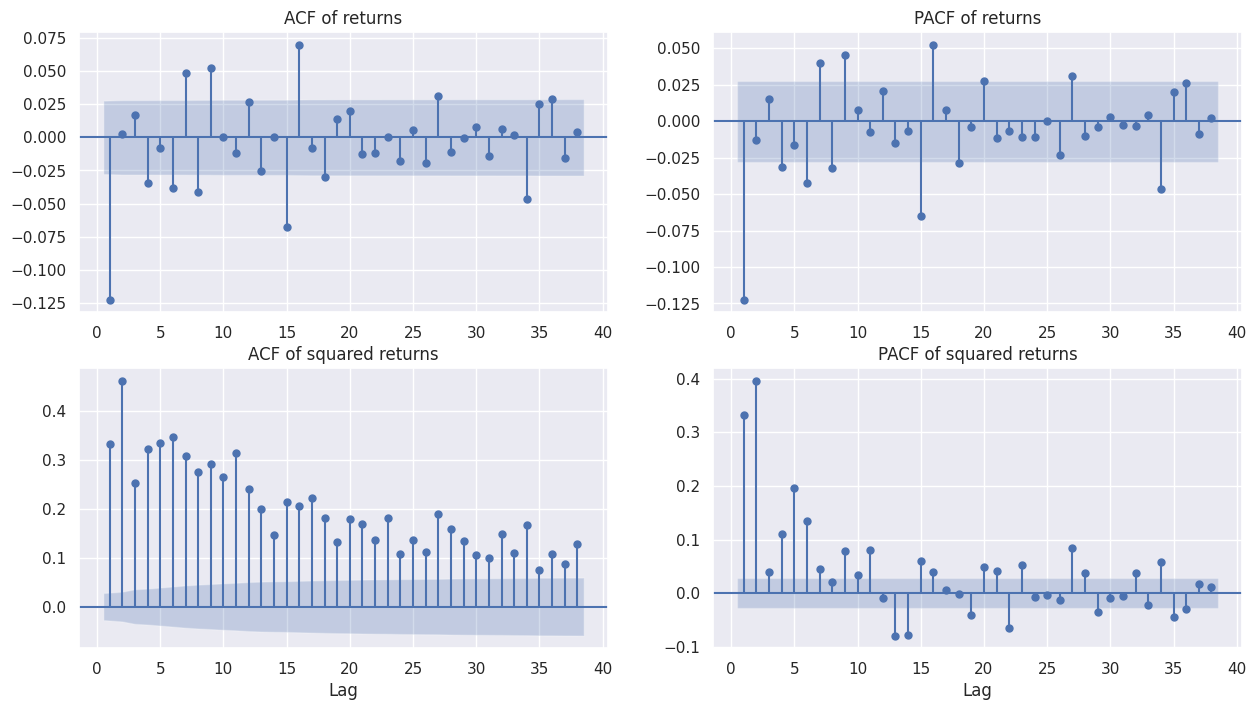

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

# RETURNS autocorrelation plot
plot_acf(returns, ax=axs[0, 0], zero=False) # zero = False to not include lag 0
axs[0, 0].set_title('ACF of returns')

# RETURNS partial autocorrelation plot
plot_pacf(returns, ax=axs[0, 1], zero=False)
axs[0, 1].set_title('PACF of returns')

# SQUARED RETURNS
plot_acf(returns**2, ax = axs[1, 0], zero=False)
axs[1, 0].set_title('ACF of squared returns')
axs[1, 0].set_xlabel('Lag')

plot_pacf(returns**2, ax = axs[1, 1], zero=False)
axs[1, 1].set_title('PACF of squared returns')
axs[1, 1].set_xlabel('Lag')

axs[0, 0].autoscale()
axs[0, 1].autoscale()
axs[1, 0].autoscale()
axs[1, 1].autoscale()

Comments:
- PACF and ACF on the returns do not give us much clues in choosing an appropriate order for p and q for the ARMA model. As we said before, squared returns are more indicative and provide more visual information with respect to the dependence of the observations.
- slow decay for ACF of the squared residuals and fast decay in the PACF. This suggest a MA structure.
- ACF of squared returns have a very small decay in the first 10 lags, and then a slightly more pronounced after lag 10
- PACF have a big cutoff value at lag 3 (also in the ACF). This would suggest and order 3 for the AR part of the ARMA mean model. Same conclusion can be drawed for the q order of the MA part, lag 3 seems as the more pronounced.

However, `ARCH` package do not currently have support for ARMA mean processes, so we'll use just the AR process.

Let's try with AR(3).

#### AR(3) mean process

In [35]:
from statsmodels.tsa.arima.model import ARIMA

AR3 = ARIMA(returns, order=(3,0,0)).fit()
print(AR3.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -8044.221
Date:                Wed, 03 Sep 2025   AIC                          16098.441
Time:                        13:14:00   BIC                          16131.048
Sample:                             0   HQIC                         16109.867
                               - 5021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.016      1.966      0.049    9.27e-05       0.064
ar.L1         -0.1237      0.007    -18.175      0.000      -0.137      -0.110
ar.L2         -0.0111      0.006     -1.998      0.0

As we can see from the summary above, the pvalue for the coefficient for lag2 is not significant. So even if by PACF suggested an AR of order 3 we'll chose an AR mean model of order 1.

#### AR(1) mean process

In [36]:
AR1 = ARIMA(returns, order=(1,0,0)).fit()
print(AR1.summary())

# Comments: Information criterias are smaller with respect to the AR
# of order 3, even if the variation if small this suggest AR(1) is better

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -8045.242
Date:                Wed, 03 Sep 2025   AIC                          16096.484
Time:                        13:14:00   BIC                          16116.048
Sample:                             0   HQIC                         16103.339
                               - 5021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.016      2.059      0.040       0.002       0.063
ar.L1         -0.1223      0.006    -19.100      0.000      -0.135      -0.110
sigma2         1.4430      0.011    128.694      0.0

Comments: Small improvement in terms of information criterias (AIC, BIC) with respect to the AR of order 3. Still, even if the variation if small this suggest AR(1) is better.

## GARCH(1, 1) Model

As we explained before, a simple GARCH(1,1) notably provide accurate fit to most of financial data.

Following the previous explanation, we'll implement the GARCH with a mean process component described by an AR(1).

In [37]:
!pip -q install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 12.0 MB/s eta 0:00:00


In [38]:
from arch.univariate import GARCH
from arch import arch_model

# Instantiate the GARCH(1,1) with AR(1) as a mean model.
garch = arch_model(returns,
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   dist = 'normal' # underlying (by hypotheses) distribution of the standardized residuals
                   )


garch_result = garch.fit(update_freq=0, last_obs="2024-06-01")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6500.043961983143
            Iterations: 12
            Function evaluations: 88
            Gradient evaluations: 12


In [39]:
print(garch_result.summary())

# Comments:
# - information criterias are clearly improved with respect to just the AR(1) model
# - all coefficients of the vol process are highly significant

                           AR - GARCH Model Results                           
Dep. Variable:                  Close   R-squared:                       0.010
Mean Model:                        AR   Adj. R-squared:                  0.010
Vol Model:                      GARCH   Log-Likelihood:               -6500.04
Distribution:                  Normal   AIC:                           13010.1
Method:            Maximum Likelihood   BIC:                           13042.6
                                        No. Observations:                 4884
Date:                Wed, Sep 03 2025   Df Residuals:                     4882
Time:                        13:14:08   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0726  1.139e-02      6.370  1.890e-

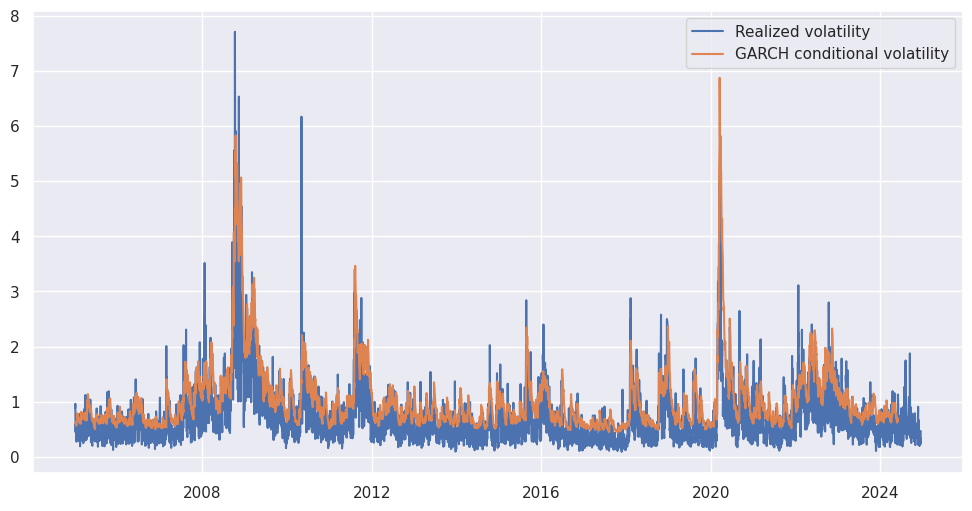

In [40]:
plt.figure(figsize=(12, 6))

plt.plot(realized_vol, label='Realized volatility')

plt.plot(garch_result.conditional_volatility, label='GARCH conditional volatility')
plt.legend()

#### Model validation

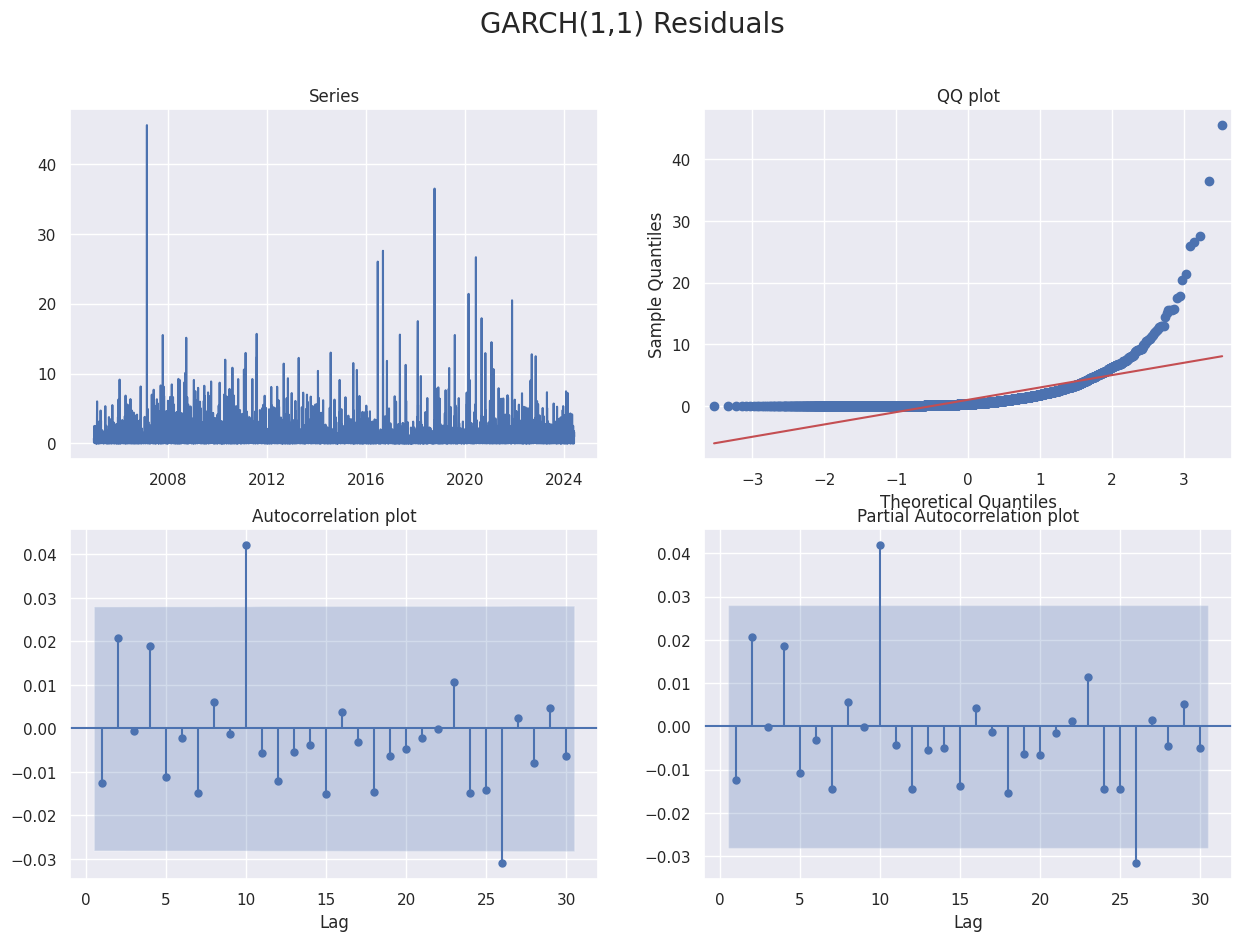

In [41]:
ts_plot(garch_result.std_resid.dropna()**2, max_lags=30, title='GARCH(1,1) Residuals')

COMMENTS:

Fat tails in the QQ plot are still persistent. The QQplot for standardized residual is a very U shaped and this suggest a strong asymmetry that should be modeled by specifying a different distribution for the standardized residuals (this distribution is one of the underlying assumption of the model that assume the std residuals to be iid) or implementing other GARCH models

However, the model has succesfully removed serial correlation (in the squared residuals) as we can observe from the ACF and PACF plots. Even if for few spikes, now residuals look fairly white noise. But is necessary to check also Ljung Box statistics.

In [42]:
# Ljung box for standardized residuals

sm.stats.acorr_ljungbox(garch_result.std_resid.dropna(), lags=None)

,lb_stat,lb_pvalue
1,0.589330,0.442678
2,1.516082,0.468583
3,2.111637,0.549562
4,2.608835,0.625259
5,7.921423,0.160620
6,11.284087,0.079983
7,12.407131,0.087940
8,13.257441,0.103294
9,13.257455,0.151299
10,15.555593,0.113080


In [43]:
# Ljung box for squared of standardized residuals
sm.stats.acorr_ljungbox(garch_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.765779,0.381526
2,2.865779,0.238618
3,2.867859,0.412451
4,4.633435,0.327017
5,5.248223,0.386344
6,5.270174,0.509657
7,6.340658,0.500582
8,6.527667,0.588340
9,6.535652,0.685339
10,15.216427,0.124368


The ljung box test exclude now autocorrelation from the standardized residuals, however, when looking at the test statistic for the squared of the standardized residuals, there is still persistence of some kind of correlation after lag 2, since all the remaining lags reject the null hypotheses of absence of autocorrelation.

This means that there are some remaining patterns or structures in the volatility that are not adequately captured by the model.

#### Specify a different underlying distribution

One solution to the problem we just faced for the residuals (as also noted by the U shaped QQ plot) is to implement a different kind of distribution, that could be for example the t of student. This kind of distribution shoul give a more leptokurtic behaviour to the residuals, that is a very common characteristic of return (as seen in the introduction to the anomalies of returns).

In [44]:
# Try with t student distribution

garch_T_result = arch_model(returns,
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   dist = 't' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2024-06-01")

print(garch_T_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6370.059773866933
            Iterations: 16
            Function evaluations: 133
            Gradient evaluations: 16
                              AR - GARCH Model Results                              
Dep. Variable:                        Close   R-squared:                       0.008
Mean Model:                              AR   Adj. R-squared:                  0.008
Vol Model:                            GARCH   Log-Likelihood:               -6370.06
Distribution:      Standardized Student's t   AIC:                           12752.1
Method:                  Maximum Likelihood   BIC:                           12791.1
                                              No. Observations:                 4884
Date:                      Wed, Sep 03 2025   Df Residuals:                     4882
Time:                              13:14:11   Df Model:                            2
                         

We can also implement a skewed t distribution and then compare the two new models with the one with gaussian residuals.

In [45]:
# Try with skewed t distribution

garch_skwT_result = arch_model(returns,
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   dist = 'skewt' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2024-06-01")

print(garch_skwT_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6347.788761272275
            Iterations: 16
            Function evaluations: 152
            Gradient evaluations: 16
                                 AR - GARCH Model Results                                
Dep. Variable:                             Close   R-squared:                       0.012
Mean Model:                                   AR   Adj. R-squared:                  0.011
Vol Model:                                 GARCH   Log-Likelihood:               -6347.79
Distribution:      Standardized Skew Student's t   AIC:                           12709.6
Method:                       Maximum Likelihood   BIC:                           12755.0
                                                   No. Observations:                 4884
Date:                           Wed, Sep 03 2025   Df Residuals:                     4882
Time:                                   13:14:12   Df Model:          

In [46]:
pd.concat([evaluate(garch_result, name='GARCH(1,1)', realized_vol=realized_vol),
           evaluate(garch_T_result, name='GARCH(1,1)_T', realized_vol=realized_vol),
           evaluate(garch_skwT_result, name='GARCH(1,1)_skwT', realized_vol=realized_vol)
            ])

,MAE,MSE,MAPE,AIC,BIC
"GARCH(1,1)",0.391402,0.275669,0.384213,13010.087924,13042.556523
"GARCH(1,1)_T",0.407963,0.312956,0.386994,12752.119548,12791.081867
"GARCH(1,1)_skwT",0.398251,0.299426,0.383028,12709.577523,12755.033561


Comments:

MSE and MAE are slightly higher for the GARCH with t and skewt student, however MAPE for the skewed GARCH is smaller. Information Criteria statistics improved. This suggest us to use one of the models with t distribution. We'll pick the skewed t since it has lower information criterias.

From now on every model will use as residuals' distribution the skewed t.

Let's look now at the Ljung Box.

In [47]:
sm.stats.acorr_ljungbox(garch_skwT_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.227362,0.633487
2,1.828350,0.400847
3,1.853235,0.603419
4,3.132444,0.535911
5,4.124091,0.531692
6,4.394316,0.623476
7,6.188843,0.517881
8,6.188887,0.626083
9,6.292030,0.710372
10,12.280590,0.266716


As we can see the LB test statistic didn't improve for larger lags, but significantly improved for the first two lags, so it's far less probable to reject the null and confirm autocorrelation in the squared residuals and hence heteroschedasticity in the residuals.

How can it be the case? The order lags specification for the Ljung Box could be wrong, or maybe the mean process specification or the garch specification are wrong.

However, before trying to correct the mean or volatility process specification we have one more test. In order to understand what is the case, we can rely on a test that check the presence of heteroschedasticity in the residuals. The null hypotheses is of NO HETEROSCHEDASTICITY.


In [48]:
from statsmodels.tsa.stattools import breakvar_heteroskedasticity_test

breakvar_heteroskedasticity_test(garch_skwT_result.std_resid.dropna())[1]

np.float64(0.965312864809772)

As we can see, the null isn't rejected and we can hence confirm that the residuals do no present any heteroschedastic behaviour (serial correlation in the squared residuals, aproximating volatility, is excluded). In this way we can skip the conclusion of the Ljung Box that was also giving contradictory results.


## Modeling of asymmetric responses of volatility

It was evident from the last model that even by implementing a t student distribution there is still much to explain in the volatility, even if the residuals appear to be white noise. Let's see if we can further improve the results.


#### Leverage effect

Leverage effect is one characteristics of the volatility that seems to react differently to a big price increase or a big price drop.

In particular, volatility tends to increase more during periods of negative returns than during periods of positive returns, as if there is was a positive correlation between past negative returns and future volatility.

This phenomenon is one of the key characteritics of volatility clustering. Since GARCH models assume that positive and negative news have a symmetric impact on the volatility of the returns, we can improve our model by implementing techniques to capture this kind of asymmetry. The asymmetry regards the response of volatility to good news and bad news. Bad news in reality have a stronger effect on volatility, resonating and increasing volatility for longer periods and with a greater impact compared to good news.

There are two extensions of the GARCH model that allows to better capture the asymmetric behaviour of the volatility: EGARCH and GJR-GARCH.


## EGARCH

The exponential generalized autoregressive conditional heteroskedastic (EGARCH) model was developed by Nelson & Cao in 1991. In particular, to allow for asymmetric effects between positive and negative asset returns, the model considers a weighted innovation:

$$g(\epsilon_t) = \theta\epsilon_t + \gamma[|\epsilon_t| - E(|\epsilon_t|)] \ \ \ \ (1)$$

where both $\epsilon_t$ and $(|\epsilon_t| - E(|\epsilon_t|))$ are zero iid sequences.
These formulation of $g(\epsilon_t)$ allows the sign and magnitude of $\epsilon_t$ to have a separate effect on the volatility.

Formally, an EGARCH(p,q) is defined as:

$$ \log{\sigma^2}_t = \omega + \sum^q_{k=1}{\beta_kg(\epsilon_{t-k})} + \sum^p_{k=1}{\alpha_k}\log{\sigma^2}_{t-k} \ \ \ \ (2)$$

Since $\log{\sigma^2}_t$ could be negative, no restrictions are applied to the parameters.



In [49]:
Egarch_skwT_result = arch_model(returns,
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'EGARCH',  # variance process
                   o = 1,
                   dist = 'skewt' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2024-06-01")

print(Egarch_skwT_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6237.888641751604
            Iterations: 20
            Function evaluations: 210
            Gradient evaluations: 20
                                AR - EGARCH Model Results                                
Dep. Variable:                             Close   R-squared:                       0.011
Mean Model:                                   AR   Adj. R-squared:                  0.010
Vol Model:                                EGARCH   Log-Likelihood:               -6237.89
Distribution:      Standardized Skew Student's t   AIC:                           12491.8
Method:                       Maximum Likelihood   BIC:                           12543.7
                                                   No. Observations:                 4884
Date:                           Wed, Sep 03 2025   Df Residuals:                     4882
Time:                                   13:14:13   Df Model:          

In [50]:
sm.stats.acorr_ljungbox(Egarch_skwT_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,1.606050,0.205048
2,2.898606,0.234734
3,2.992172,0.392834
4,6.034843,0.196561
5,6.038965,0.302446
6,6.335151,0.386712
7,6.398307,0.494085
8,6.399564,0.602568
9,6.554886,0.683352
10,8.472568,0.582779


Standardized residuals are finally behaving like white noise. We can clearly see that from the Ljung Box test now also higher order lags of the test don't reject the null hypotheses. This hence mean that a model capable of dealing with the volatility asymmetry is better suited for this type of market data and we should continue and focus on this models.

Now we can also look and compare EGARCH statistics with the other models:

In [51]:
pd.concat([evaluate(garch_result, name='GARCH(1,1)', realized_vol=realized_vol),
           evaluate(garch_T_result, name='GARCH(1,1)_T', realized_vol=realized_vol),
           evaluate(garch_skwT_result, name='GARCH(1,1)_skwT', realized_vol=realized_vol),
           evaluate(Egarch_skwT_result, name='EGARCH(1,1)_skwT', realized_vol=realized_vol)
            ])

,MAE,MSE,MAPE,AIC,BIC
"GARCH(1,1)",0.391402,0.275669,0.384213,13010.087924,13042.556523
"GARCH(1,1)_T",0.407963,0.312956,0.386994,12752.119548,12791.081867
"GARCH(1,1)_skwT",0.398251,0.299426,0.383028,12709.577523,12755.033561
"EGARCH(1,1)_skwT",0.381357,0.247214,0.378310,12491.777284,12543.727042


Comments: EGARCH improved a lot the error measures, especially the MSE. Also, information criterias improved, even if by a little.

## GJR-GARCH

For a GJR-GARCH(1,1), the variance process is:

$$\sigma^2_t =  \omega + \alpha_1\epsilon^2_{t-1} + \gamma_1\epsilon^2_{t-1}I_{t-1} + \beta_1\sigma^2_{t-1} $$

where $I_{t-1}$ is an indicator function that:

$$ I_{t-1} = \begin{cases} 1 &\text{if } \epsilon_{t-1} < 0 \\ 0 &\text{if } \epsilon_{t-1} \ge 0 \end{cases} $$

By implementing the indicator function in the volatility process the model gives one extra parameters $\gamma_1$ that emphasises the effect of negative past news on the conditional volatility and allows the model to better retrace the asymmetry in the volatility.

In [52]:
GJRgarch_skwT_result = arch_model(returns,
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   o = 1, # order of the asymmetric innovation, =1 means GJR GARCH
                   dist = 'skewt' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2024-06-01")

print(GJRgarch_skwT_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6253.960900086
            Iterations: 18
            Function evaluations: 185
            Gradient evaluations: 18
                               AR - GJR-GARCH Model Results                              
Dep. Variable:                             Close   R-squared:                       0.011
Mean Model:                                   AR   Adj. R-squared:                  0.011
Vol Model:                             GJR-GARCH   Log-Likelihood:               -6253.96
Distribution:      Standardized Skew Student's t   AIC:                           12523.9
Method:                       Maximum Likelihood   BIC:                           12575.9
                                                   No. Observations:                 4884
Date:                           Wed, Sep 03 2025   Df Residuals:                     4882
Time:                                   13:14:14   Df Model:             

In [53]:
sm.stats.acorr_ljungbox(GJRgarch_skwT_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.264533,0.607023
2,0.310768,0.856086
3,1.121521,0.771881
4,1.929156,0.748787
5,3.082452,0.687276
6,3.181728,0.785717
7,4.799387,0.684430
8,4.827984,0.775793
9,5.004389,0.833926
10,6.017353,0.813803


GJR shows again good signs, as with EGARCH, higher order lags of the Ljung Box statistics improved compared to non-asymmetric GARCH models.

In [54]:
pd.concat([evaluate(garch_result, name='GARCH(1,1)', realized_vol=realized_vol),
           evaluate(garch_T_result, name='GARCH(1,1)_T', realized_vol=realized_vol),
           evaluate(garch_skwT_result, name='GARCH(1,1)_skwT', realized_vol=realized_vol),
           evaluate(Egarch_skwT_result, name='EGARCH(1,1)_skwT', realized_vol=realized_vol),
           evaluate(GJRgarch_skwT_result, name='GJR-GARCH(1,1)_skwT', realized_vol=realized_vol)
            ])

,MAE,MSE,MAPE,AIC,BIC
"GARCH(1,1)",0.391402,0.275669,0.384213,13010.087924,13042.556523
"GARCH(1,1)_T",0.407963,0.312956,0.386994,12752.119548,12791.081867
"GARCH(1,1)_skwT",0.398251,0.299426,0.383028,12709.577523,12755.033561
"EGARCH(1,1)_skwT",0.381357,0.247214,0.378310,12491.777284,12543.727042
"GJR-GARCH(1,1)_skwT",0.395966,0.306717,0.378261,12523.921800,12575.871559


As we can see, GJR-GARCH stepped back from the results of the EGARCH both in termes of error measures but also in terms of information criterias.

For this reason, EGARCH is currently the best model.

#### News Impact Curve

As we saw, asymmetric models are better able to capture volatility irregular behaviour in the market. But why?

News Impact Curves are a way to observe the aymmetric response of volatility with respect to the market news. Given an estimated model, it depicts the next-period volatility that would result from various positive and negative shocks.

Before discussing the utility of news impact curves, we should define a function that is able to plot one relative to the basic GARCH model, and one for the GJR-GARCH model (for simplicity, we'll omit the one for the EGARCH).

The equations for a NIC, that plot residual at time t-1 versus the conditional variance at time t, were defined in the paper "Measuring and Testing the Impact of News on Volatility " written by Engle in 1993.

As we know, the residuals in the context of an ARCH model are calculated as $\epsilon_t = r_t - m_t$ . Engle defines these in the paper as *"unexpected returns"* and treat them as a *"collective measure of news at time t"*.

Following this definition he explains that a *"positive $\epsilon_t$ (an unexpected increase in price) suggests the arrival of good news, while a negative $\epsilon_t$ (an unexpected decrease in price) suggests the arrival of bad news. Further, a large value of $|\epsilon_t|$ implies that the news is "significant" or "big" in the sense that it produces a large unexpected change in price."*
These paper hence try to create a visual way to inspect the the capability of GARCH models to capture the asymmetry of positive and negative news with respect to the object of the forecast, the volatility.


**GARCH NIC**  <br>
The equation for the GARCH(1,1) News Impact Curve, following the equations in the paper of Engle, is:

$$\sigma_t = A + \alpha\epsilon^2_{t-1} $$

where,
- $\sigma_t$ is the conditional variance at time t
- $\epsilon_{t-1}$ is the residual at time t-1
- $A = \omega + \beta\sigma^2$
- $\sigma$ is the unconditional return variance, calculated as $\frac{\omega}{1 + \alpha}$
- $\omega , \alpha, \beta $ are the parameters estimated in the GARCH(1,1) model


**GJR-GARCH NIC** <br>
The two equations for the GJR-GARCH(1,1,1) News Impact Curve from the Engle paper are:

$$\sigma_t = A + \alpha\epsilon_{t-1}^2, \ \ \text{for} \  \epsilon_{t-1}>0 $$
$$\sigma_t = A + (\alpha + \gamma)\epsilon_{t-1}^2, \ \ \text{for} \ \epsilon_{t-1}<0 $$

where,
- $\sigma_t$ is the conditional variance at time t
- $\epsilon_{t-1}$ is the residual at time t-1
- $A = \omega + \beta\sigma^2$
- $\sigma^2$ is the unconditional variance, equal to $\frac{\omega}{(1-\alpha - \frac{\gamma}{2}- \beta)}$
- $\omega , \alpha, \beta, \gamma $ are the parameters estimated in the GJRGARCH(1,1,1) model


For this two models, the residuals at time t-1 are plotted against the conditional variance at time t, calculated according to the above equations.

In [55]:
def NIC(model, name : str):

    vols = model.conditional_volatility.dropna() # extract sigma_t from the model
    epsi = model.resid.shift(1).dropna() #extract residuals and shift by 1 to get epsilon_t-1

    # merge the two series so that they have the same dates (and same observations)
    merge = pd.merge(vols, epsi, left_index=True, right_index=True, how='inner')

    # create a new column for the squared residuals
    merge['epsi_squared'] = merge.iloc[:,1]**2

    ## GARCH(1,1)
    if name == 'GARCH':
        omega = model.params[2] #constant term
        alpha = model.params[3]
        beta = model.params[4]
        unco_var = omega / (1 + alpha) #unconditional variance

        A = omega + beta * unco_var

        # Create the column for the conditional variance of the News Impact Curve
        merge['ht'] = A + (alpha * merge['epsi_squared'])


    ## GJR-GARCH(1,1)
    elif name == 'GJR':

        omega = model.params[2] #constant term
        alpha = model.params[3]
        beta = model.params[5]
        gamma = model.params[4]
        unco_var = omega / (1 - alpha - (gamma/2) - beta) #unconditional variance

        A = omega + beta * unco_var

        # Define the function that will calculate A according to the two formulas conditions
        def gjr(value):
            if value > 0:
                return (A + alpha * (value**2))
            elif value < 0:
                return (A + (alpha + gamma) * (value**2))

        # Apply the function to create the ht column
        # Create the column for the conditional variance of the News Impact Curve
        merge['ht'] = merge.iloc[:,1].apply(gjr)

    merge.sort_values(by='resid', inplace=True)
    plt.plot(merge.iloc[:,1].values, merge['ht'].values)
    plt.xlabel('$\epsilon_{t-1}$')
    plt.ylabel('$\sigma^2_t$')
    plt.title(f'News Impact Curve for {name}')


Let's visualize the two NIC curves. What these two curves tell us?

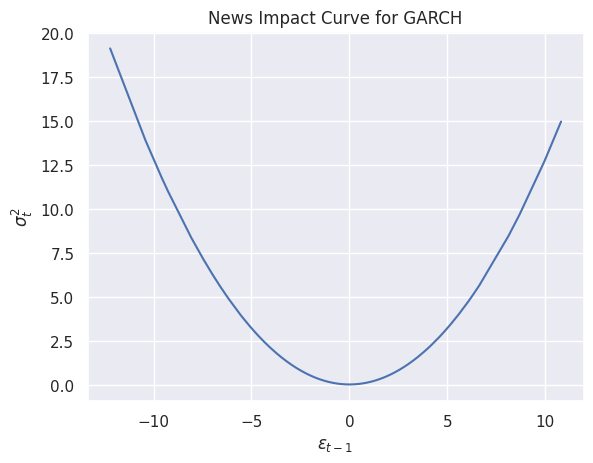

In [56]:
NIC(garch_skwT_result, name='GARCH')

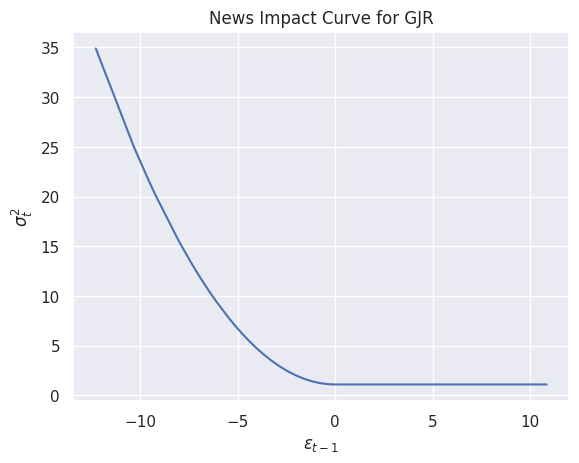

In [57]:
NIC(GJRgarch_skwT_result, name='GJR')

As we can see, the two curves appear to be clearly different. The GJR-GARCH curve, that was developed to better capture the asymmetric information of the residuals onto the conditional variance in the context of the Leverage Effect, has a steeper curve for the negatives values of the past residuals (the news) and an almost horizontal curve (that appear extremely horizontal due to the scale of the plot) for the positive values of the residuals. What does this implies? That the GJR GARCH was actually able to measure and replicate the volatility asymmetry that can be traced back just by observing the volatility clusters. Instead, the basic GARCH, is not able to do so since its NIC curve is almost perfectly symmetrical and hence the model regards equally a positive or negative past residuals for determining the conditional volatility.

## Forecast Model Evaluation

EGARCH is chose as the best model, both in terms of Error Measures and Information Criterias.

The last thing to test is its capability of forecasting in out of sample data. We recall that all the models were fitted until '2024-05-31' so we have aproximately a 6 months forecast horizon that last until the '2024-12-13'.

We'll perform a 1 step ahead forecast, so each day after the 31st of May will be forecasted based on the previous observation residuals, and forecasted conditional variances, as well as on the parameters of the EGARCH model fitted with data from 2005 to 31st may of 2024.


In [58]:
## Now let's forecast the volatility with our model (we fitted data until 2024-01-01)
# Default is one step ahead forecast
forecasts_1 = Egarch_skwT_result.forecast(reindex=False)

for_vol_1 = np.sqrt(forecasts_1.variance) #extract forecasted volatility for 1 step ahead
for_vol_1

for_vol_1.head()
# column h.1 represent the forecast of each day (each row) for the following day
# row 2024-05-31 is the forecast the 31st of May for the 1st of June

,h.1
Date,
2024-05-31,0.728676
2024-06-03,0.689407
2024-06-04,0.653088
2024-06-05,0.614050
2024-06-06,0.583843


The first row 2024-05-31 is the forecast made the 31st of May for the 1st of June.

Thus, in order to have the forecast value in the concerned day of the forecast, we'll shift the dataframe by 1 day.

In [59]:
# for_vol_1 = for_vol_1.shift(1).dropna()
for_vol_1.head()

,h.1
Date,
2024-05-31,0.728676
2024-06-03,0.689407
2024-06-04,0.653088
2024-06-05,0.614050
2024-06-06,0.583843


Now, the first row contain the forecast made for the 1st of June.

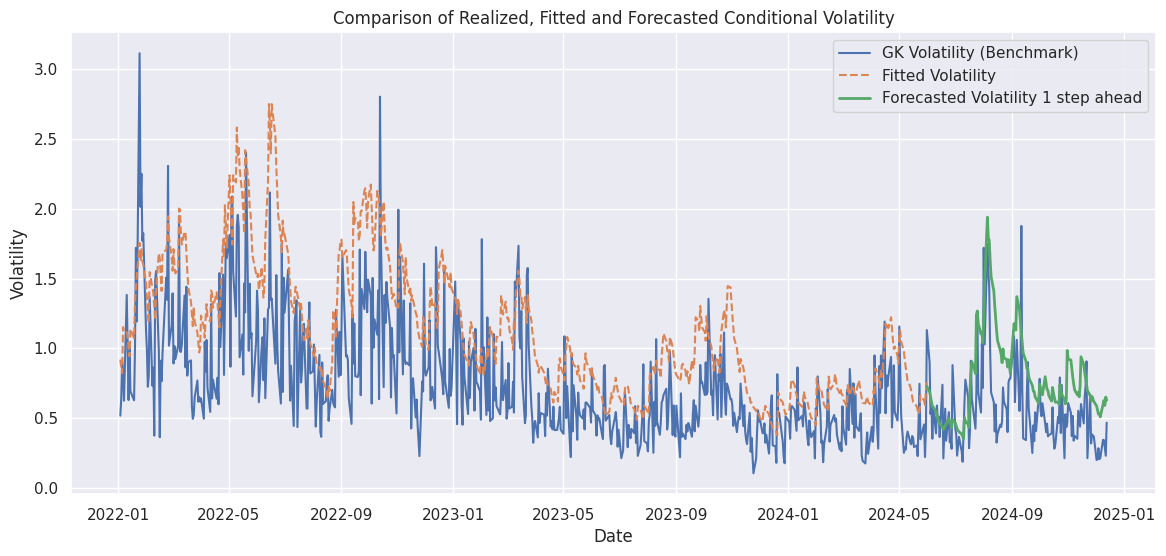

In [60]:
# Plot realized volatility vs fitted volatility vs forecasted volatility (focus from 2022 on)

fitted = Egarch_skwT_result.conditional_volatility.dropna() # store the conditional vola of the EGARCH model

start = '2022-01-01'   # define the start point for the plot

plt.figure(figsize=(14, 6))
plt.plot(realized_vol[start: ], label='GK Volatility (Benchmark)', linewidth=1.5) #realized VOL
plt.plot(fitted[start: ], label='Fitted Volatility', linestyle='dashed', linewidth=1.5) # FITTED
plt.plot(for_vol_1, label='Forecasted Volatility 1 step ahead', linewidth=2) # 1 step ahead forecaste vol


plt.title('Comparison of Realized, Fitted and Forecasted Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

As we can see the model isn't catching all the variations in volatility that the GK provide (since GK implement OHLC data and hence is more sensible), but is really fitting well the trend in the data. Once again we should highlight how there is not a real measure of realized volatility so GK is being considered as a sort of 'benchmark'.

Nevertheless, all the above analysis pointed out how EGARCH(1,1) with skewed t distribution for the residuals is overall the best model to fit and forecast the volatility in the S&P 500 market.

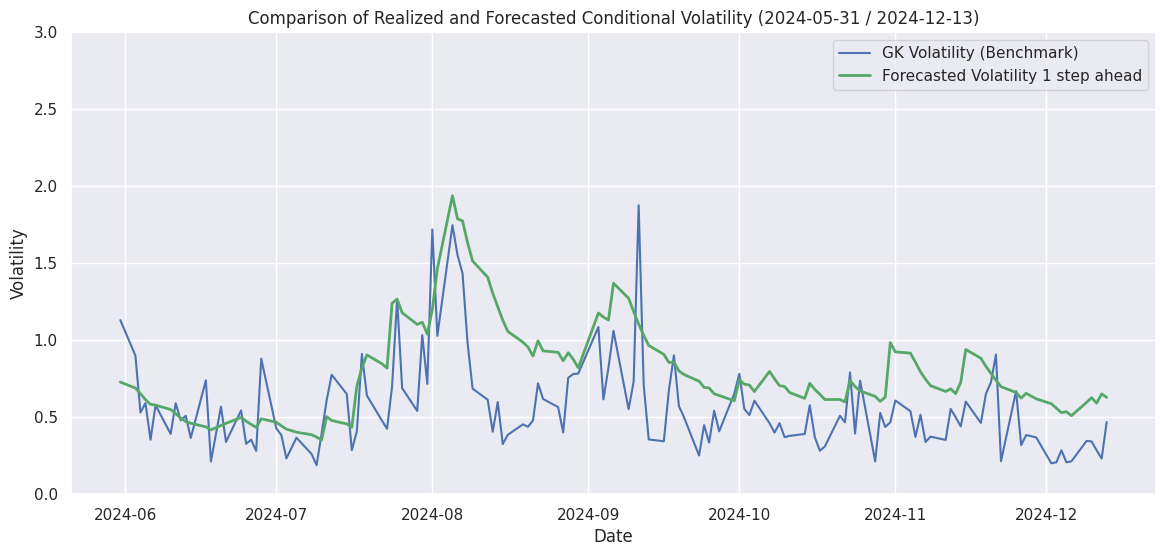

In [61]:
# let's zoom in a little (only the forecast period)
start = str(for_vol_1.index[0])[:10]

plt.figure(figsize=(14, 6))
plt.plot(realized_vol[start: ], label='GK Volatility (Benchmark)', linewidth=1.5) # realized VOL (GK)
plt.plot(for_vol_1, label='Forecasted Volatility 1 step ahead', linewidth=2, color = 'C2') # 1 step ahead forecaste vol


plt.title(f'Comparison of Realized and Forecasted Conditional Volatility ({start} / {str(for_vol_1.index[-1])[:10]})')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.ylim([0, 3])
plt.legend()
plt.show()

In [62]:
print('MAE: ', mean_absolute_error(for_vol_1, realized_vol[for_vol_1.index[0]:]))
print('MSE: ', mean_squared_error(for_vol_1, realized_vol[for_vol_1.index[0]:]))
print('MAPE: ', mean_absolute_percentage_error(for_vol_1, realized_vol[for_vol_1.index[0]:]))

MAE:  0.2820934241974793
MSE:  0.11672068139001011
MAPE:  0.3535272431506597


Error measures appears to be lower than those for in sample data. This could be a case since the in sample series is much longer than the out of sample.

So to conclude, we can choose the **EGARCH(1,1)** with skewed t distribution for the residuals as the most suitable model to capture the volatility anomalies in the S&P 500 index and also to forecast its volatility, at least for 1 step ahead forecasts.